# COSE DA FARE

1. analisi computazione micro con FPU
2. analisi prezzi

<br>

Organizzazione github:
- cartella con i files da caricare; Datasets
- cartella contenente i notebooks; Notebooks
- cartella contenente il progetto C; C Project
- weights of the models; Weights
- fuori dalla cartella mettere PDF tesi;

# AUTOENCODER ECG PER ANOMALY DETECTION

## Introduzione

***Our Dataset***

I segnali ECG acquisiti sono stati inizialmente filtrati (usando medie mobili e filtri hardware) e poi suddivisi in finestre utilizzando un altro notebook. Successivamente, le finestre ottenute sono state esportate in un file CSV. In questo file, ogni riga rappresenta una finestra del segnale, mentre ogni colonna corrisponde a un campione temporale all'interno della finestra (in totale 120 campioni per finestra, un valore scelto per bilanciare la risoluzione del segnale con i limiti computazionali e di memoria tipici dei microcontrollori, rispettando sempre il teorema del campionamento di Nyquist-Shannon).

Tuttavia, all'interno del pool di dati acquisiti non vi era certezza dell'assenza di anomalie, rendendo quindi necessario un processo di etichettatura. Sebbene il numero complessivo di segnali fosse sufficiente per un addestramento completo, non eravamo in grado di etichettarli accuratamente in autonomia.

Per ovviare a questo problema, è stato richiesto il supporto di un ex infermiere di cardiologia, al quale è stato affidato il compito di selezionare in modo casuale 100 segnali etichettati come normali, garantendo così una base di dati affidabile per la fase di Fine Tuning (vedere sezione Training Process).

Naturalmente, in uno scenario ideale si sarebbe dovuto etichettare l'intero dataset, ma ciò non è stato possibile per limiti di tempo e risorse.

<br>

***Online Dataset***

I dati etichettati a disposizione non erano sufficienti per un addestramento efficace del modello. Per questo motivo, si è reso necessario integrare un dataset online che utilizzasse la stessa derivazione ECG adottata per l'acquisizione (derivazione DI) e che contenesse segnali comparabili per morfologia ai nostri, oltre a essere privi di anomalie (etichettati quindi come **classe 0**).

È stato individuato il dataset [ECG-ID Database v1.0.0](https://physionet.org/content/ecgiddb/1.0.0/), composto da segnali normali provenienti da diverse persone. Tuttavia, i segnali di questo dataset erano stati acquisiti con una frequenza di campionamento pari a 500 Hz, superiore rispetto a quella dei nostri dati (120 campioni al secondo). Per rendere compatibili i dati, si è quindi proceduto con un'operazione di downsampling alla frequenza di campionamento utilizzata nel nostro sistema.

<br>

***Anomaly Dataset***

Un ulteriore passaggio fondamentale è stato l’individuazione di un dataset online contenente segnali anomali, che fossero quanto più possibile compatibili con i nostri tracciati ECG, sia in termini di derivazione (DI) sia di caratteristiche morfologiche. Tuttavia, non è stato trovato un dataset con segnali DI anomali già etichettati.

L’unico dataset che si avvicinava ai nostri requisiti era il dataset X, contenente tracciati ECG di diverse persone, all'interno dei quali erano presenti anche anomalie, seppur non etichettate in modo esplicito.

Come nel caso del nostro dataset acquisito, si è quindi richiesto il supporto di un ex infermiere specializzato in cardiologia per l’etichettatura manuale e l’individuazione delle onde anomale, al fine di isolare 100 segnali anomali (**classe 1**).

Anche in questo caso, l’etichettatura completa dell’intero dataset sarebbe stata auspicabile, ma è stata limitata a causa di vincoli di tempo e risorse disponibili.

<br>

***Autoencoder***

Il modello di intelligenza artificiale adottato è un **autoencoder**, scelto in alternativa a un **classificatore** tradizionale per diverse ragioni.
1. scarso numero di anomalie: il dataset contiene poche anomale etichettate (100), il che potrebbe introdurre un forte bias in fase di addestramento. È stato deciso di non utilizzare tecniche di data augmentation, per evitare di alterare la distribuzione naturale dei dati e per non rischiare fenomeni di overfitting dovuti alla ripetizione artificiale delle poche anomalie presenti (con o senza aggiunta di rumore). Questo rappresenta un limite significativo per un classificatore, che richiede tipicamente un bilanciamento tra le classi per funzionare correttamente;
2. capacità di generalizzazione dell’autoencoder: a differenza del classificatore, che può riconoscere solo le anomalie su cui è stato esplicitamente addestrato, l’autoencoder si basa sulla ricostruzione del segnale originale, dunque in grado di riconoscere anche anomalie non etichettate;
3. l’autoencoder rappresenta un modello ancora poco esplorato nel contesto dei microcontrollori, e per questo motivo si è scelto di valutarne pregi e limiti all’interno di un ambiente a risorse limitate.

<br>

***Training Process***

In una prima fase, il modello è stato addestrato utilizzando esclusivamente i 100 segnali acquisiti e etichettati come classe 0 (normali). Tuttavia, i risultati ottenuti non sono stati soddisfacenti. Anche includendo 100 segnali normali provenienti da un dataset online, mantenendo quindi un totale di 200 dati normali per evitare bias nell’autoencoder, il modello non ha mostrato miglioramenti significativi.

Per questo motivo, si è deciso di modificare l’approccio: il modello è stato inizialmente addestrato solo sui dati online etichettati come normali. Successivamente, è stata avviata una fase di Transfer Learning con Fine Tuning, utilizzando sia 50 segnali acquisiti che 50 segnali dal dataset online, sempre appartenenti alla classe 0. In questa fase, i pesi dell’encoder sono stati freezati e il modello è stato raffinato agendo solamente sul decoder.

Grazie a questo approccio è stato possibile adattare il modello alla ricostruzione dei segnali acquisiti localmente, utilizzando soltanto 100 dati acquisiti normali.

<br>

***Hyperparameter Tuning***

L’autoencoder è in grado di segnalare la presenza di un’anomalia quando l’errore di ricostruzione supera una soglia prestabilita, definita ad esempio tramite analisi ROC. Questo approccio permette di generalizzare anche su anomalie mai viste in fase di addestramento, evitando la necessità di etichettare esplicitamente i segnali anomali nel training set.

Tuttavia, per garantire che il modello fosse non solo efficace ma anche compatibile con le limitazioni computazionali dei microcontrollori, è stato necessario un processo di tuning approfondito. Sono state valutate diverse configurazioni del modello, tenendo conto sia delle prestazioni in termini di rilevamento (es. AUC della curva ROC) sia del costo computazionale.

Alla fine, i parametri ottimali sono stati selezionati confrontando le curve AUC ottenute per ogni combinazione di iperparametri, in modo da bilanciare accuratezza e leggerezza del modello.

<br>

***Pruning vs Limited Model***

Per finire, sono state valutate le performances con un taglio dei pesi con il metodo del Pruning e sia testando un modello con già presente un numero inferiore di neuroni, paragonabile al modello iniziale con Pruning.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
import numpy as np
import random
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import requests

# il modello è stato poi testato con differenti seeds per la riproducibilità e randomicità
seed = 2025             # 42, 157, 2025
np.random.seed(seed)
train_url = 'https://raw.githubusercontent.com/DitucSpa/AnomalyDetectionAutoencoderECG/main/Datasets/train.csv'
test_url = 'https://raw.githubusercontent.com/DitucSpa/AnomalyDetectionAutoencoderECG/main/Datasets/test.csv'
combined_url = 'https://raw.githubusercontent.com/DitucSpa/AnomalyDetectionAutoencoderECG/main/Datasets/combined.csv'
anomaly_url = 'https://raw.githubusercontent.com/DitucSpa/AnomalyDetectionAutoencoderECG/main/Datasets/anomaly.csv'
url = 'https://raw.githubusercontent.com/DitucSpa/AnomalyDetectionAutoencoderECG/main/Weights/autoencoder.weights.h5'
url_tuned = 'https://raw.githubusercontent.com/DitucSpa/AnomalyDetectionAutoencoderECG/main/Weights/autoencoder_tuned.weights.h5'
url_limited = 'https://raw.githubusercontent.com/DitucSpa/AnomalyDetectionAutoencoderECG/main/Weights/autoencoder_limited.weights.h5'
url_tuned_limited = 'https://raw.githubusercontent.com/DitucSpa/AnomalyDetectionAutoencoderECG/main/Weights/autoencoder_tuned_limited.weights.h5'


# the fun applies MinMaxScaler, shuffle, plots some examples with some prints info
# params are the dataset as pandas object and if the fun needs to split the dataset
def preprocessing(dataset, split=True, shuffle=True):
  dataset = (dataset - dataset.min(axis=1).values[:, None]) / (dataset.max(axis=1).values[:, None] - dataset.min(axis=1).values[:, None])
  x = dataset.values
  if shuffle:
    np.random.shuffle(x)

  # plot di alcune onde randomiche
  fig, axs = plt.subplots(2, 3, figsize=(15, 6))
  axs = axs.flatten()
  random_wave = random.sample(range(x.shape[0]), 6)
  for i in range(6):
      axs[i].plot(x[random_wave[i]])
      axs[i].set_title(f"Window {random_wave[i]+1}")
      axs[i].set_xlabel("Samples")
      axs[i].set_ylabel("Normalized Quantization Step")
      axs[i].grid(True)
  plt.tight_layout()
  plt.show()

  # plot unico con tutte le 6 onde sovrapposte
  plt.figure(figsize=(10, 4))
  for i in range(6):
      plt.plot(x[random_wave[i]], label=f"Window {random_wave[i]+1}")
  plt.xlabel("Samples")
  plt.ylabel("Normalized Quantization Step")
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

  print(f'Original Shape: {dataset.shape}')
  if split:
    # split train/validation 75% / 25%
    x_train, x_val = train_test_split(x, test_size=0.25, random_state=42)
    print(f"x_train shape: {x_train.shape}, x_val shape: {x_val.shape}")
    return x_train, x_val
  else:
    return x

def plot_loss(data, model):
  # calcolo della loss per ogni finestra
  total_loss = tf.reduce_mean(tf.abs(model(data) - data), axis=1)

  # max and min loss values and indeces
  max_index = tf.argmax(total_loss).numpy()
  max_value = total_loss[max_index].numpy()
  min_index = tf.argmin(total_loss).numpy()
  min_value = total_loss[min_index].numpy()
  print(f"Indice con errore massimo:  {max_index}")
  print(f"Valore dell'errore massimo: {max_value}")
  print(f"Indice con errore minimo:   {min_index}")
  print(f"Valore dell'errore minimo:  {min_value}")

  plt.figure(figsize=(10, 4))
  plt.plot(total_loss, marker='.', linestyle='-')
  plt.title("Losses")
  plt.xlabel("Window")
  plt.ylabel("MAE")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

def plot_history(history):
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train vs Validation Loss (con EarlyStopping)')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

## Datasets

### ONLINE DATASET

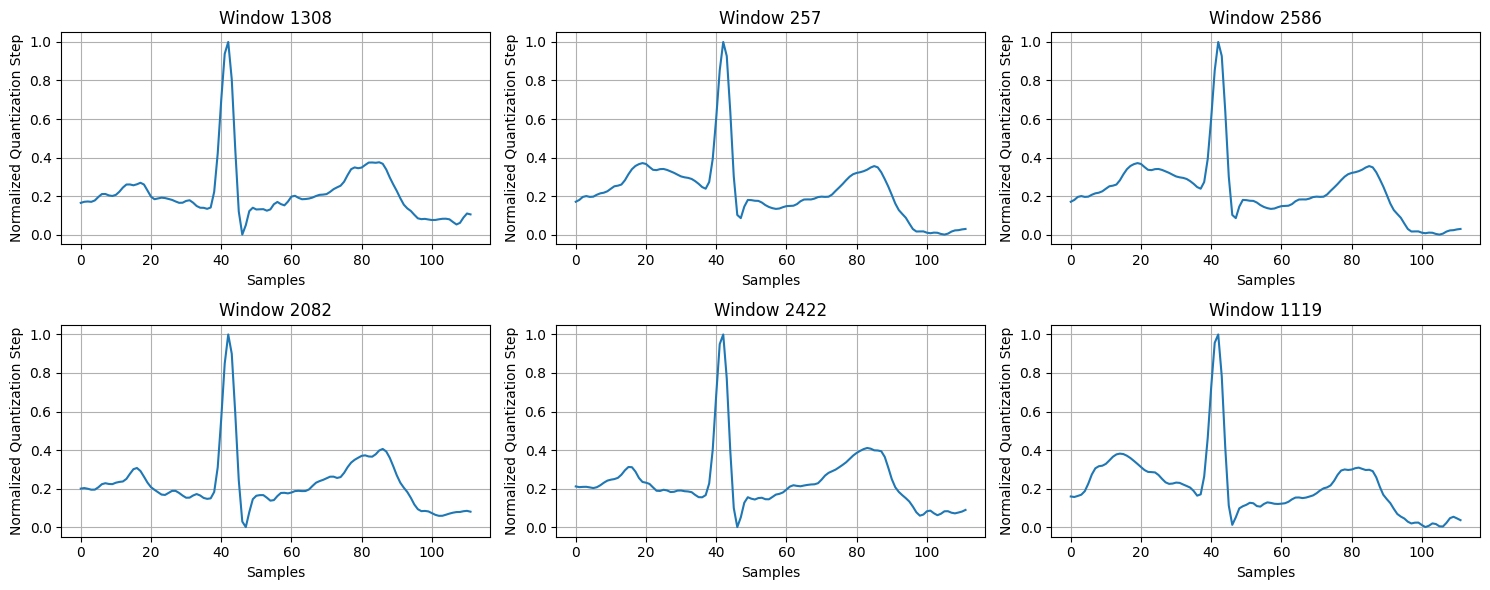

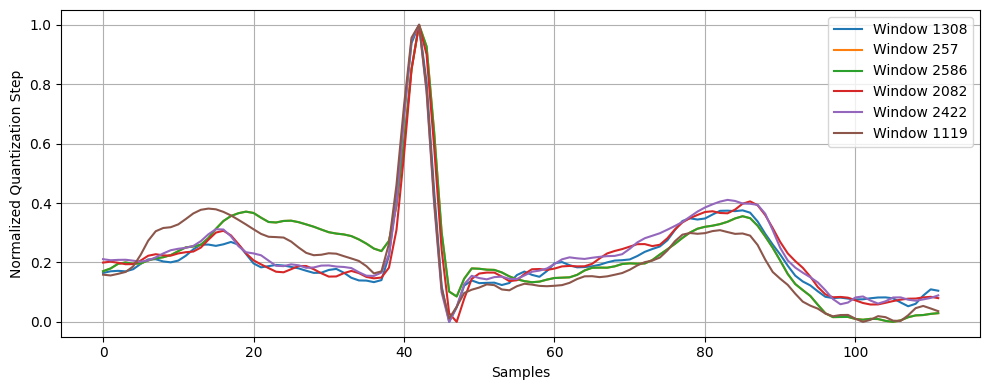

Original Shape: (3120, 112)
x_train shape: (2340, 112), x_val shape: (780, 112)


In [ ]:
df_train = pd.read_csv(train_url)
x_train, x_val = preprocessing(df_train)

### ANOMALY DATASET

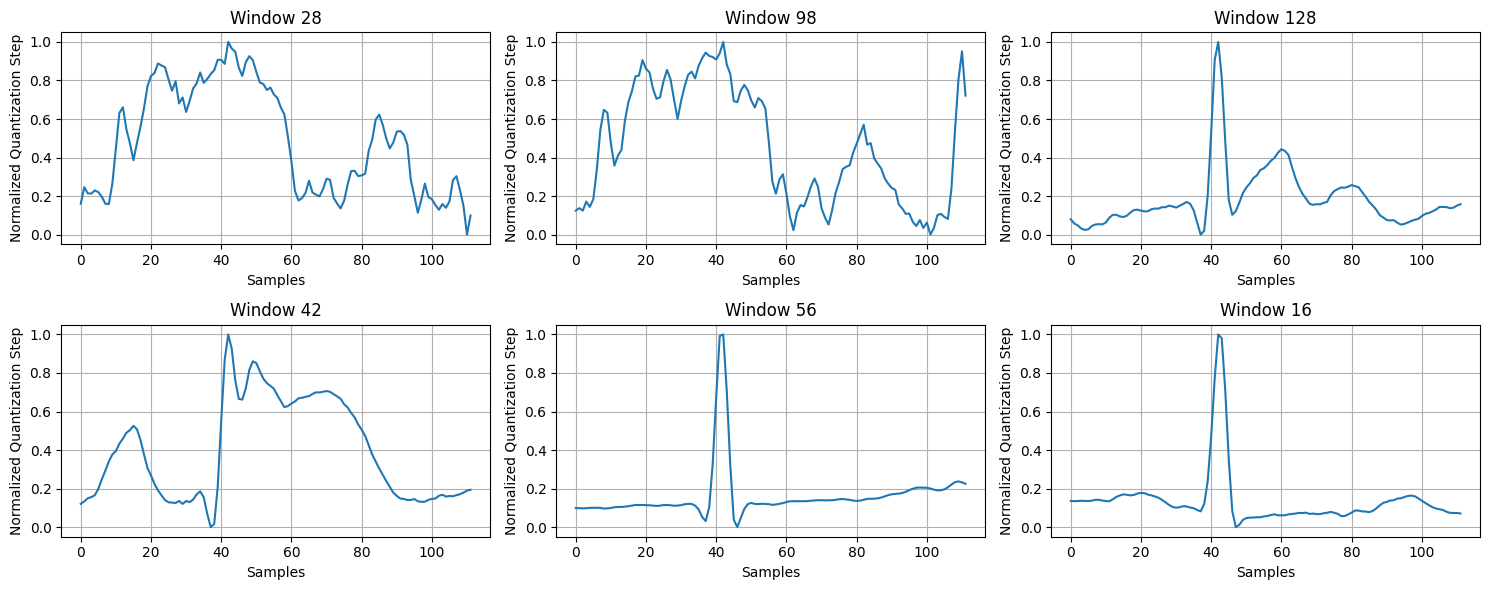

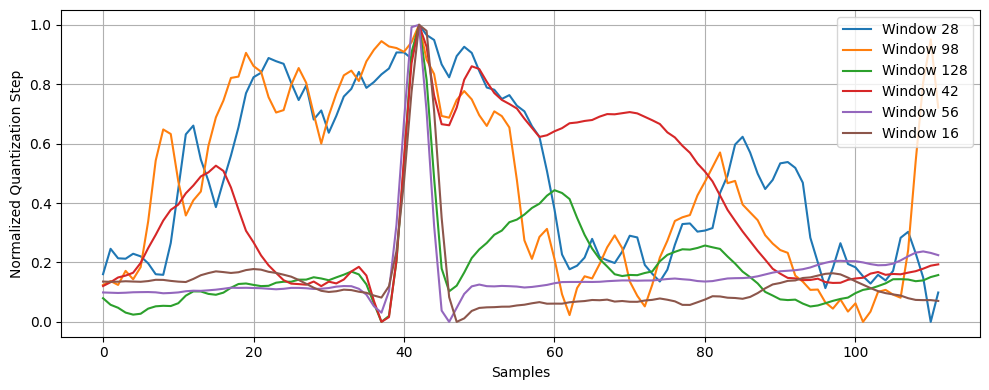

Original Shape: (132, 112)


In [ ]:
df_anomaly = pd.read_csv(anomaly_url)
x_anomaly = preprocessing(df_anomaly, split=False)

### COMBINED DATASET
This part includes the upload of 100 normal waves using the online dataset and 100 normal waves gets out from our dataset (labelled as normal).

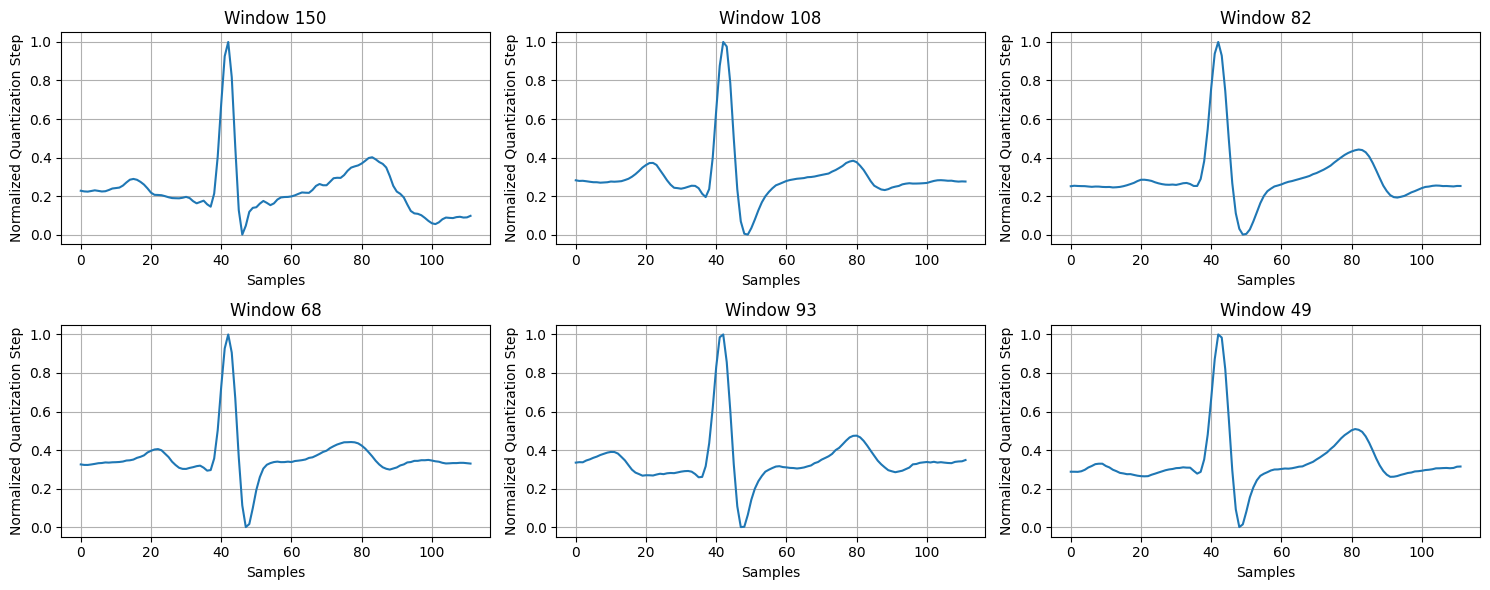

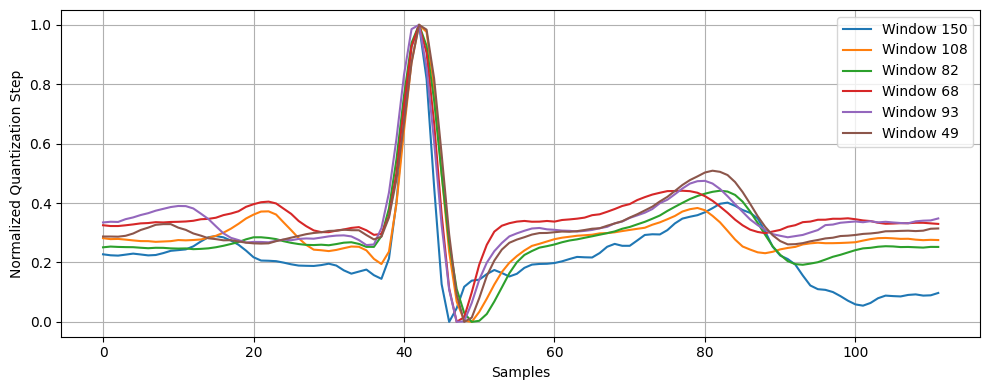

Original Shape: (200, 112)
x_train shape: (150, 112), x_val shape: (50, 112)


In [37]:
df_combined = pd.read_csv(combined_url)
x_combined_train, x_combined_val = preprocessing(df_combined)

### Test

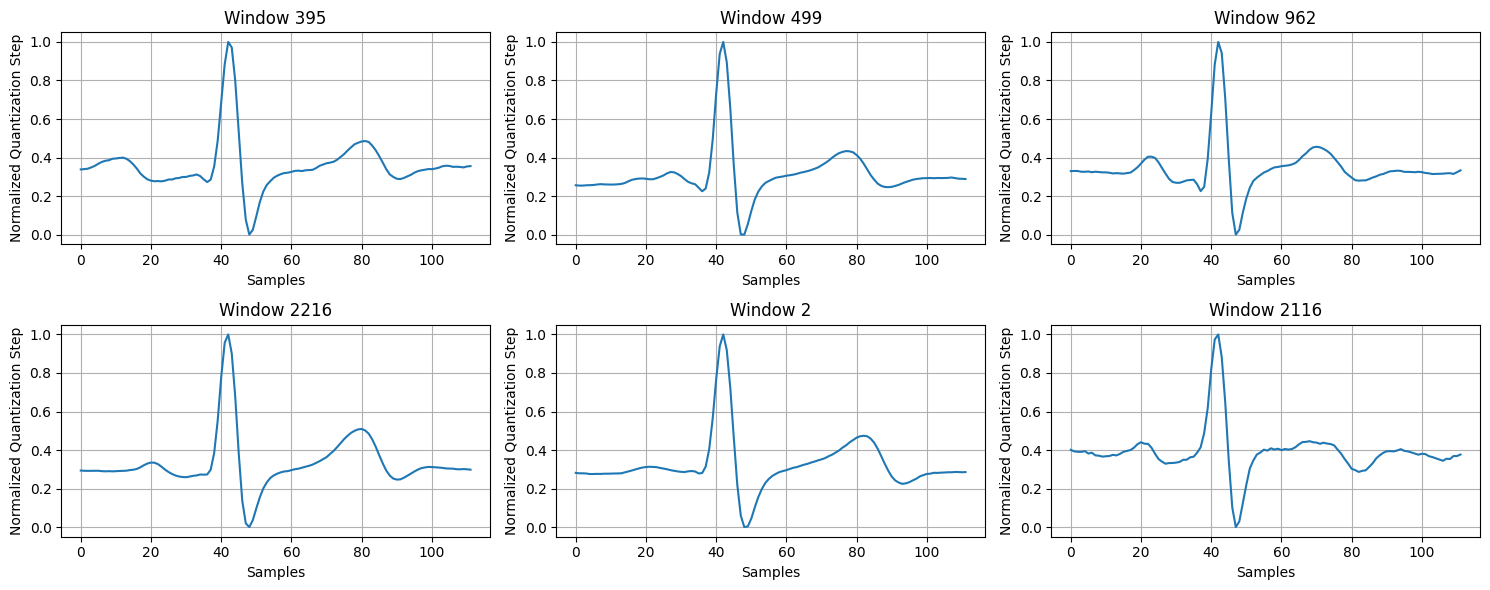

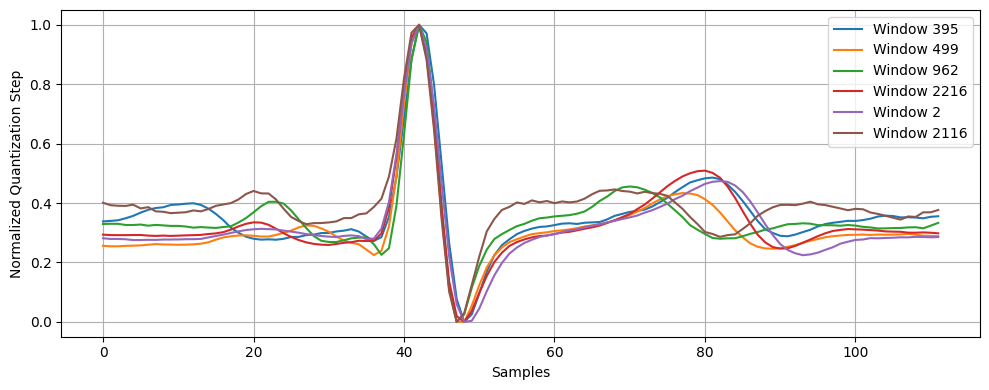

Original Shape: (2541, 112)


In [ ]:
df_test = pd.read_csv(test_url)
x_test = preprocessing(df_test, split=False, shuffle=False)

## MODEL

Per l’addestramento dell’autoencoder sono stati testati diversi iperparametri, tra cui il valore del dropout, il numero di neuroni nei layer nascosti e la dimensione del batch.
Come funzioni di attivazione, è stata utilizzata ReLU negli hidden layers per il suo basso costo computazionale, scelta motivata dal vincolo che il modello deve essere eseguito su un microcontrollore.
Nell’output layer è stata invece adottata la hard sigmoid, una semplificazione della sigmoide tradizionale, anch’essa selezionata per garantire efficienza computazionale.

La loss utilizzata è stata MAE con Adam per l'aggiornamento dei pesi.


In [ ]:
# hyperparams
batch_size = 16
dropout = 0.3
epochs = 100
patience = 5
regularization = 0.000 # troppi pochi pesi, non va regularization

class Autoencoder(Model):
    def __init__(self, size=100, dropout=0):
        super(Autoencoder, self).__init__(name="ECG_Autoencoder")
        self.size = size

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dropout(dropout),
            layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dense(2, activation='relu', kernel_regularizer=regularizers.l1(regularization))
        ], name="Encoder")

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dropout(dropout),
            layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dense(self.size, activation='hard_sigmoid')
        ], name="Decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# test del modello con un dummy
autoencoder = Autoencoder(x_train.shape[1], dropout=dropout)
dummy_input = tf.zeros((1, x_train.shape[1]))
output = autoencoder(dummy_input)
print("Dimensione output dal modello:", output.shape)
autoencoder.compile(optimizer='adam', loss='mae')
n_weights = autoencoder.encoder.count_params() + autoencoder.decoder.count_params()
print(f"Numero totale di pesi addestrabili: {n_weights}, size in Byte: {n_weights*4}") # weights in fp32
print(f"Numero pesi Encoder: {autoencoder.encoder.count_params()}")
print(f"Numero pesi Decoder: {autoencoder.decoder.count_params()}")

Dimensione output dal modello: (1, 112)
Numero totale di pesi addestrabili: 2010, size in Byte: 8040
Numero pesi Encoder: 950
Numero pesi Decoder: 1060


## TRAIN

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2640 - val_loss: 0.0524
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0436 - val_loss: 0.0361
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0360 - val_loss: 0.0344
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0344 - val_loss: 0.0328
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0332 - val_loss: 0.0313
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312 - val_loss: 0.0296
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0298 - val_loss: 0.0278
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0280 - val_loss: 0.0266
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - val_loss: 0.0260
Epoch 10/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0259 - val_loss: 0.0257
Epoch 11/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0251 - val_loss: 0.0256
Epoch 12/100
147/147 ━━━━━━━━━━━━━━━━━━━━

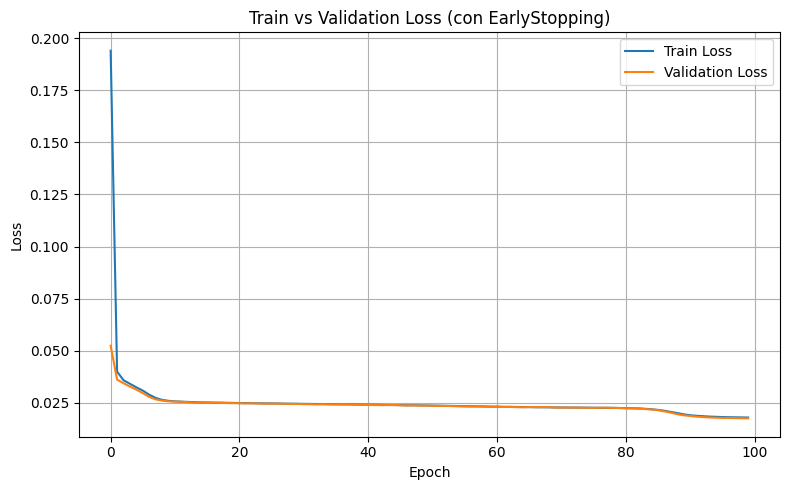

In [ ]:
# EarlyStopping callback (i.e stoppa il traning se la loss del validation set non migliora per 5 epoche)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)
history = autoencoder.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, x_val),
    callbacks=[early_stop]
)
plot_history(history)

Dal grafico si osserva l'assenza di overfitting, con un andamento coerente tra la loss di training e quella di validazione. Si nota inoltre un netto calo della loss attorno all’epoca 85-86: è probabile che, grazie all’ottimizzazione con Adam (che utilizza un learning rate adattivo), il modello sia riuscito a convergere verso un minimo particolarmente favorevole.

Indice con errore massimo:  44
Valore dell'errore massimo: 0.05366984382271767
Indice con errore minimo:   7
Valore dell'errore minimo:  0.008672826923429966


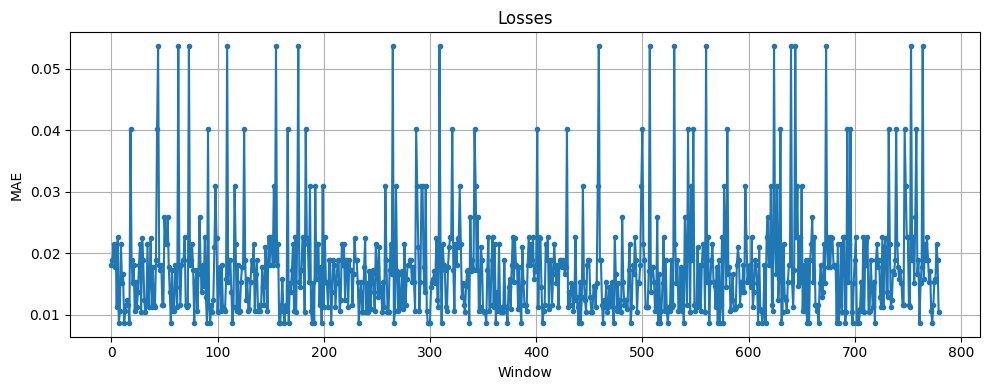

In [ ]:
plot_loss(x_val, autoencoder)

Plottando le loss per ogni finestra ECG presente nel VAL notiamo che l'errore massimo è stato 0.05366 con una media di 0.0175. Ora salviamo i pesi del modello e proviamo a vedere le performances sul nostro dataset e sulle anomalie.

In [ ]:
# save the weights
autoencoder.save_weights('autoencoder.weights.h5')

In [ ]:
# load of the weights
response = requests.get(url)
autoencoder(tf.zeros((1, x_combined_train.shape[1])))
autoencoder.load_weights('autoencoder.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Indice con errore massimo:  78
Valore dell'errore massimo: 0.5335153341293335
Indice con errore minimo:   88
Valore dell'errore minimo:  0.0470084622502327


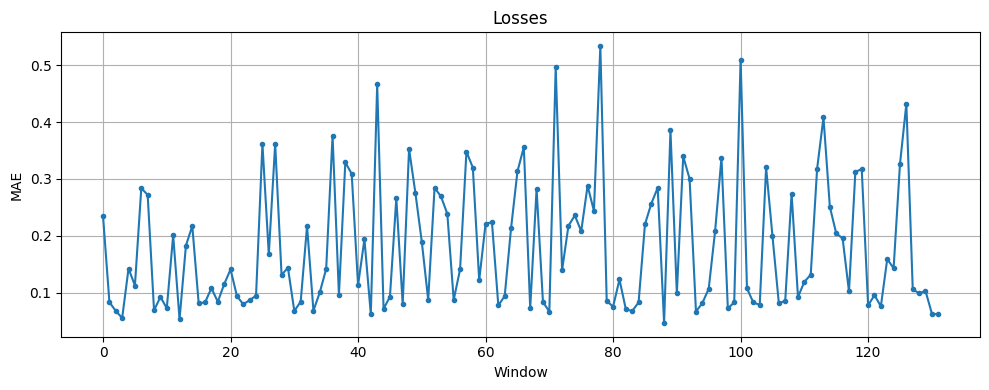

In [ ]:
plot_loss(x_anomaly, autoencoder)

Il modello si comporta egregiamente anche per le anomalie; infatti, possiamo notare che la media delle Loss è ben al di sopra del valore massimo di Loss incontrata nel training, con qualche eccezione.

Indice con errore massimo:  618
Valore dell'errore massimo: 0.2068924903869629
Indice con errore minimo:   1931
Valore dell'errore minimo:  0.05210769921541214


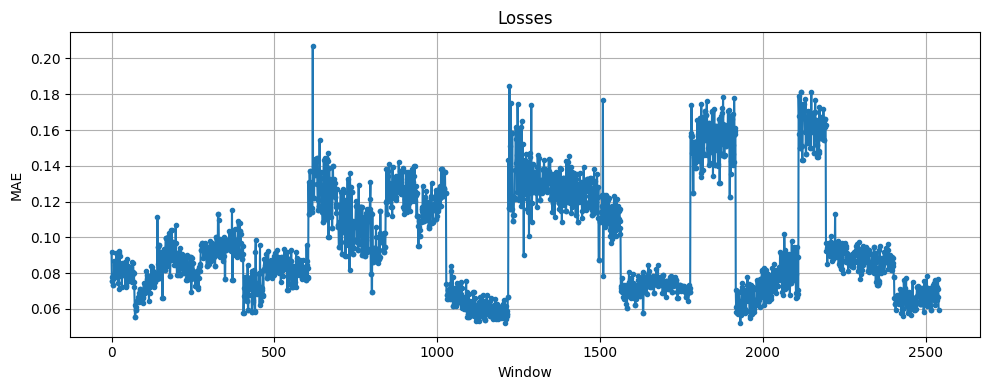

In [ ]:
plot_loss(x_test, autoencoder)

Come possiamo notare, il modello performa molto male con i nostri dati acquisiti con un diverso strumento di misura. Dunque, si potrebbe optare per un Fine Tuning per migliorare anche le Loss per il nostro dataset.
NOTA: nel test set i dati non vengono mischiati perché non vi è il motivo di farlo ed anche perché così è possibile risalire alla descrizione dell'individuo in base alla Loss.

## Fine Tuning

In [ ]:
# load of the weights
autoencoder(tf.zeros((1, x_combined_train.shape[1])))
response = requests.get(url)
with open('autoencoder.weights.h5', 'wb') as f:
    f.write(response.content)
autoencoder.load_weights('autoencoder.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0593 - val_loss: 0.0477
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0518 - val_loss: 0.0421
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0436 - val_loss: 0.0401
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0443 - val_loss: 0.0381
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0421 - val_loss: 0.0373
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0403 - val_loss: 0.0364
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0396 - val_loss: 0.0359
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0391 - val_loss: 0.0352
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0386 - val_loss: 0.0349
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0386 - val_loss: 0.0347
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0372 - val_loss: 0.0343
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0374 - val_lo

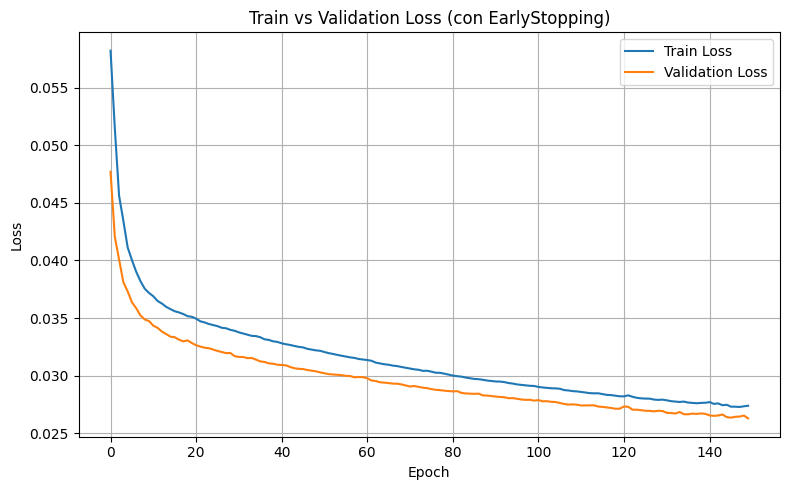

In [ ]:
# freeze di tutti i pesi dell'encoder
count = 0
for layer in autoencoder.encoder.layers:
    if count!=3:
      layer.trainable = False
    count+=1

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)
history = autoencoder.fit(
    x_combined_train, x_combined_train,
    epochs=150,
    batch_size=24,
    validation_data=(x_combined_val, x_combined_val),
    callbacks=[early_stop]
)
plot_history(history)

In questo caso, è stato necessario addestrare il modello con molte più epoche rispetto al solito (i.e. 15-20 epoche) per via dei pochi dati ed il validation set ha mostrato performances migliori rispetto al training set, probabilmente perché il validation mostrava esempi più semplici.

In [ ]:
# save the weights
autoencoder.save_weights('autoencoder_tuned.weights.h5')

In [ ]:
# load of the weights
response = requests.get(url_tuned)
with open('autoencoder_tuned.weights.h5', 'wb') as f:
    f.write(response.content)
autoencoder(tf.zeros((1, x_combined_train.shape[1])))
autoencoder.load_weights('autoencoder_tuned.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Indice con errore massimo:  41
Valore dell'errore massimo: 0.05093303322792053
Indice con errore minimo:   18
Valore dell'errore minimo:  0.010391787625849247


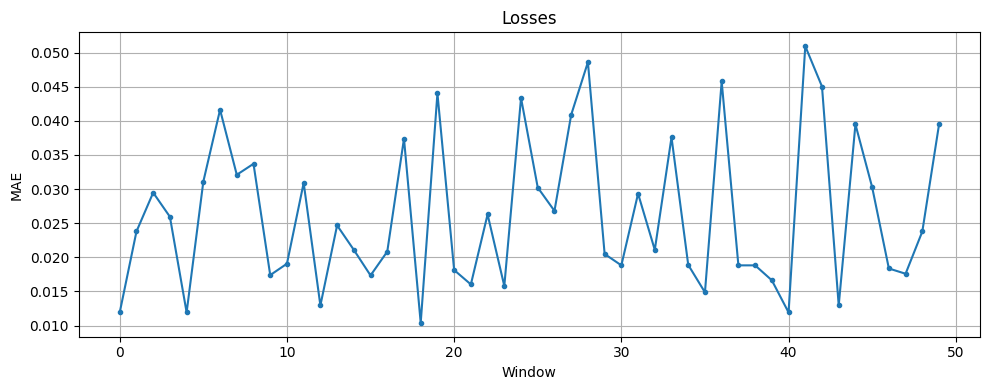

In [ ]:
plot_loss(x_combined_val, autoencoder)

Indice con errore massimo:  23
Valore dell'errore massimo: 0.05093303322792053
Indice con errore minimo:   1
Valore dell'errore minimo:  0.010391787625849247


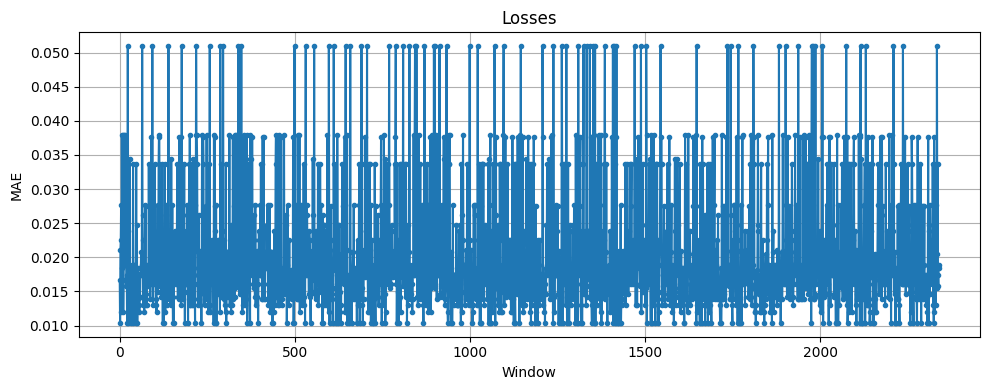

In [ ]:
plot_loss(x_train, autoencoder)

Come possiamo notare, le prestazioni sul dataset online sono rimaste ancora super validi ed, anzi, l'errore massimo è diminuito da 0.05366 a 0.0509, nonostante un aumento del valore medio di errore della Loss.
Ora proviamo a vedere le prestazione del modello dopo il tuning con anomalie ed i nostri dati di test.

Indice con errore massimo:  78
Valore dell'errore massimo: 0.3873986303806305
Indice con errore minimo:   88
Valore dell'errore minimo:  0.0476703941822052


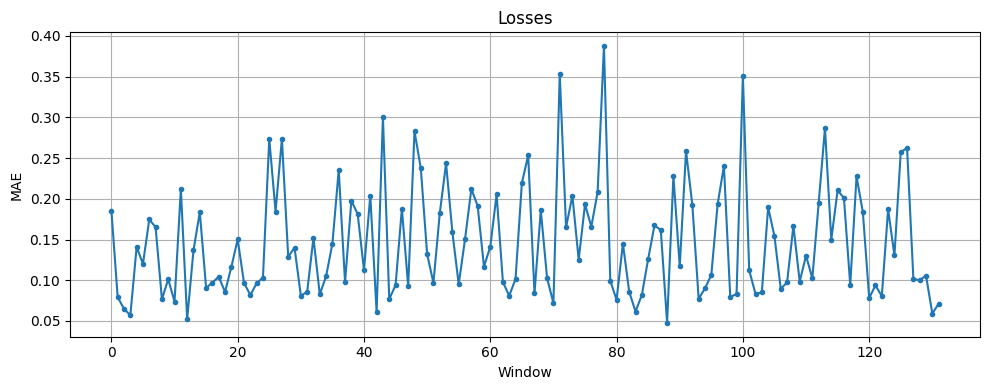

In [ ]:
plot_loss(x_anomaly, autoencoder)

Indice con errore massimo:  2633
Valore dell'errore massimo: 0.3873986303806305
Indice con errore minimo:   2103
Valore dell'errore minimo:  0.017694002017378807


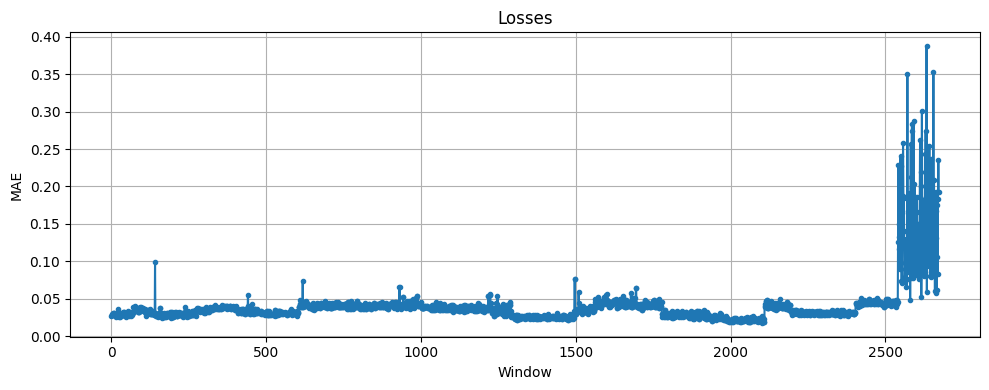

In [ ]:
plot_loss(np.concat([x_test,x_anomaly]), autoencoder)

Ora, le nostre finestre ECG di test presentano Loss ben lontane dalle Loss delle anomalie, dimostrando che il modello si è adattato correttamente anche ai nostri dati con qualche eccezione.

## ROC-AUC

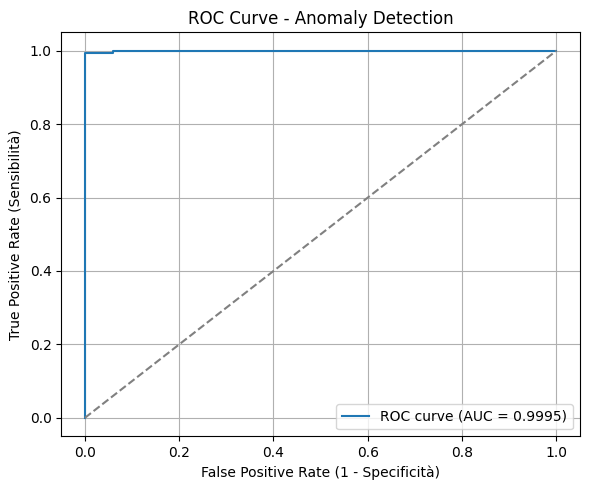


=== Massima Sensibilità (max TPR) ===
Soglia: 0.047670
True Positive Rate (Sensibilità): 1.0000
False Positive Rate: 0.0600
Accuracy: 0.9835


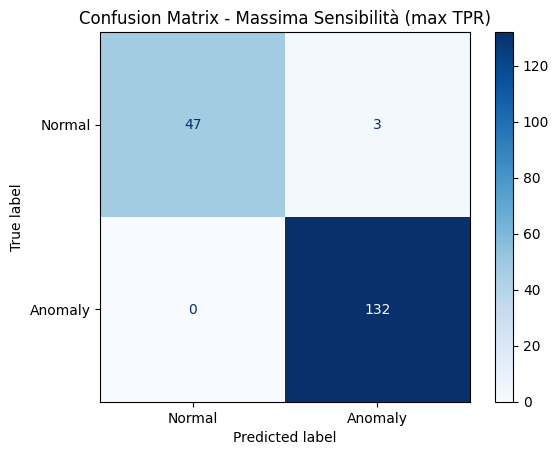


=== Minimo FPR (max Specificità) ===
Soglia: inf
True Positive Rate (Sensibilità): 0.0000
False Positive Rate: 0.0000
Accuracy: 0.2747


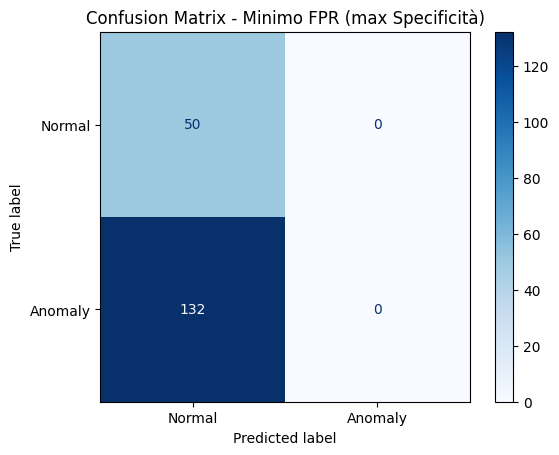


=== Punto più vicino a (0,1) ===
Soglia: 0.052474
True Positive Rate (Sensibilità): 0.9924
False Positive Rate: 0.0000
Accuracy: 0.9945


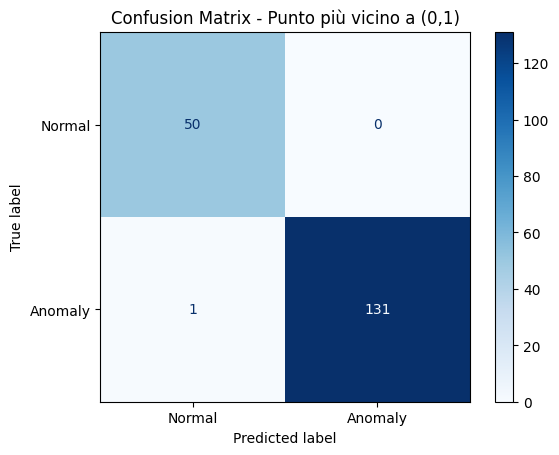

In [ ]:
def evaluate_thresholds(autoencoder, x_normal, x_anomaly):
    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        roc_curve, auc,
        confusion_matrix, ConfusionMatrixDisplay,
        accuracy_score
    )

    # Calcola la loss
    normal_loss = tf.reduce_mean(tf.abs(autoencoder(x_normal) - x_normal), axis=1)
    anomaly_loss = tf.reduce_mean(tf.abs(autoencoder(x_anomaly) - x_anomaly), axis=1)
    total_loss = tf.concat([normal_loss, anomaly_loss], axis=0).numpy()
    true_labels = np.concatenate([
        np.zeros(x_normal.shape[0], dtype=int),
        np.ones(x_anomaly.shape[0], dtype=int)
    ])

    # ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, total_loss)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate (1 - Specificità)")
    plt.ylabel("True Positive Rate (Sensibilità)")
    plt.title("ROC Curve - Anomaly Detection")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Trova indici soglie di interesse
    idx_max_tpr = np.argmax(tpr)
    idx_min_fpr = np.argmin(fpr)
    idx_closest_01 = np.argmin(np.sqrt((fpr - 0)**2 + (tpr - 1)**2))

    threshold_results = {
        "Massima Sensibilità (max TPR)": idx_max_tpr,
        "Minimo FPR (max Specificità)": idx_min_fpr,
        "Punto più vicino a (0,1)": idx_closest_01
    }

    # Dizionario dei risultati
    output_thresholds = {}

    for name, idx in threshold_results.items():
        threshold = thresholds[idx]
        pred_labels = (total_loss >= threshold).astype(int)
        cm = confusion_matrix(true_labels, pred_labels)
        acc = accuracy_score(true_labels, pred_labels)

        tpr_val = tpr[idx]
        fpr_val = fpr[idx]

        print(f"\n=== {name} ===")
        print(f"Soglia: {threshold:.6f}")
        print(f"True Positive Rate (Sensibilità): {tpr_val:.4f}")
        print(f"False Positive Rate: {fpr_val:.4f}")
        print(f"Accuracy: {acc:.4f}")

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

        output_thresholds[name] = {
            "threshold": threshold,
            "TPR": tpr_val,
            "FPR": fpr_val,
            "accuracy": acc
        }

    return output_thresholds
thresholds = evaluate_thresholds(autoencoder, x_combined_val, x_anomaly)

## Analisi Segnali (scegliendo TP)

In [ ]:
threshold = thresholds['Massima Sensibilità (max TPR)']['threshold']
test_loss = tf.reduce_mean(tf.abs(autoencoder(x_test) - x_test), axis=1).numpy()
anomalous_indices = np.where(test_loss >= threshold)[0]
print(f"Elementi sopra la soglia: {len(anomalous_indices)} su {len(x_test)}")
print(f"Percentuale: {len(anomalous_indices) / len(x_test) * 100:.2f}%")
print(anomalous_indices)

Elementi sopra la soglia: 69 su 2541
Percentuale: 2.72%
[ 141  441  610  618  930  931  942  943  971  973  984  985  986  987
 1217 1218 1222 1223 1224 1247 1496 1497 1509 1561 1568 1571 1590 1591
 1592 1593 1594 1596 1600 1601 1602 1622 1623 1631 1644 1645 1651 1661
 1662 1678 1684 1691 1694 1695 1722 1768 2116 2117 2161 2421 2431 2447
 2448 2449 2462 2472 2473 2474 2477 2503 2504 2506 2508 2534 2537]


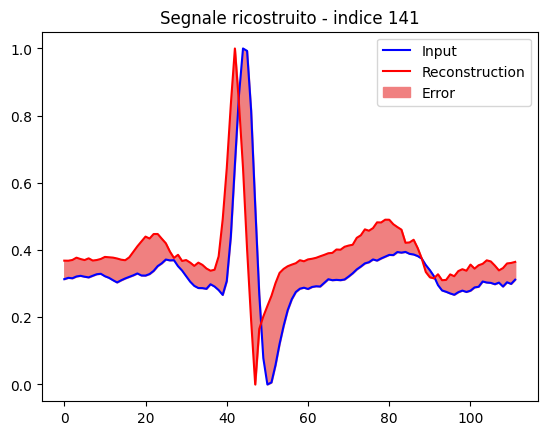

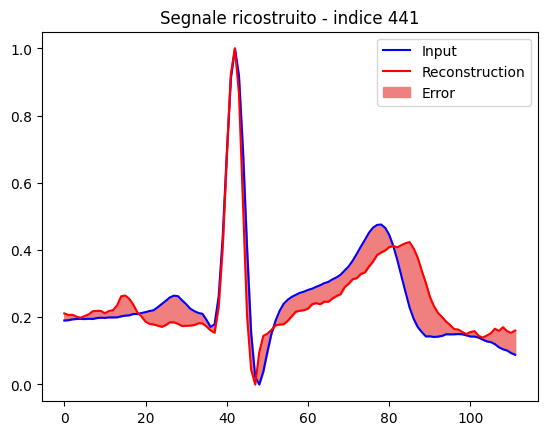

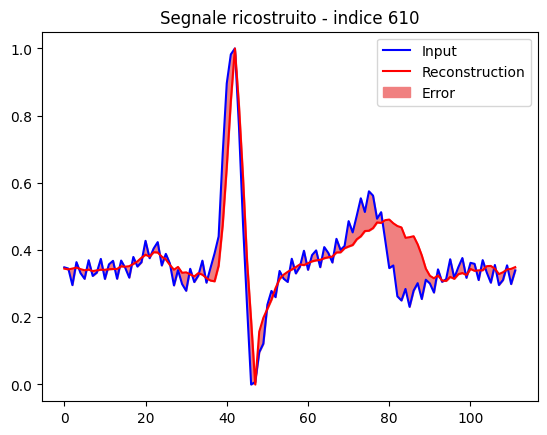

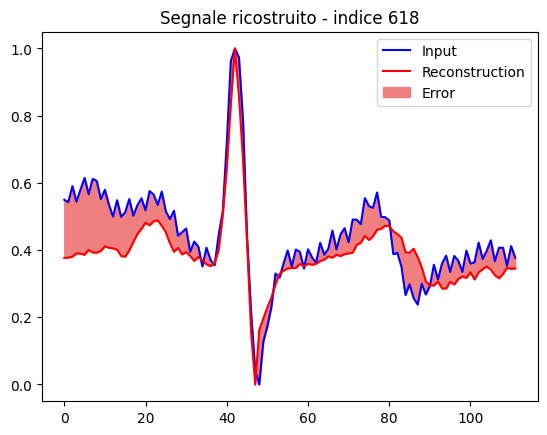

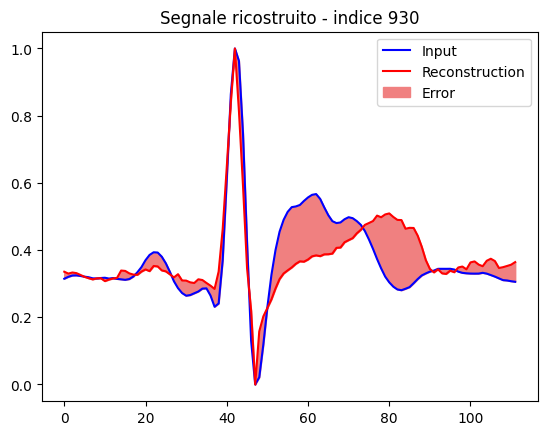

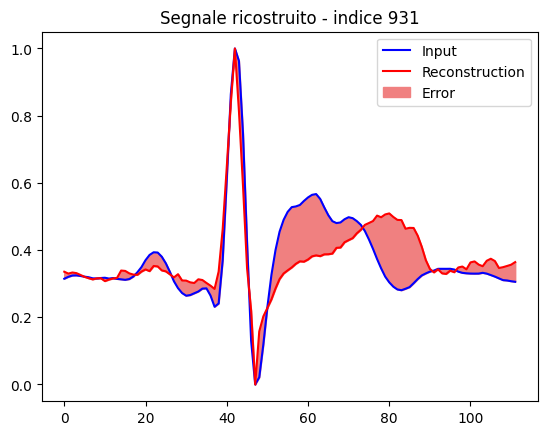

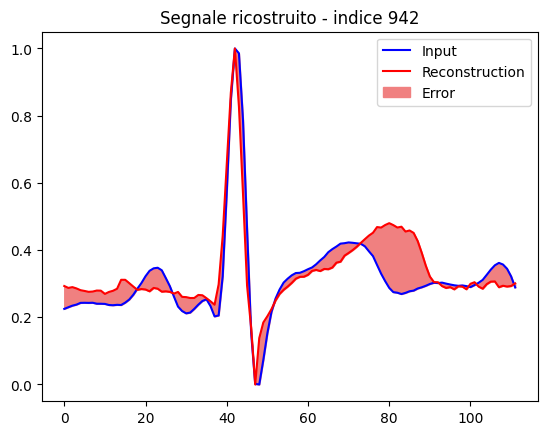

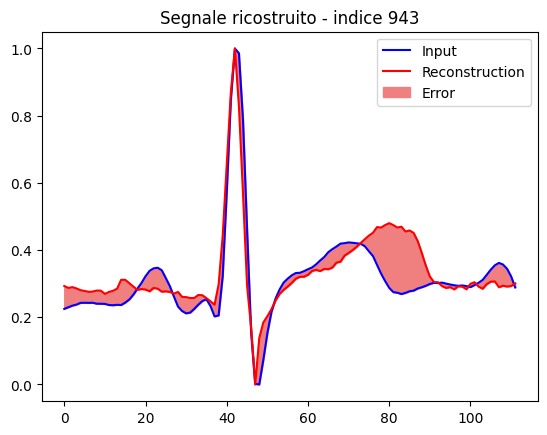

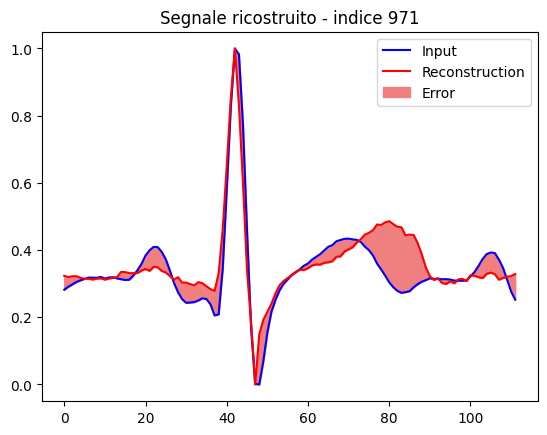

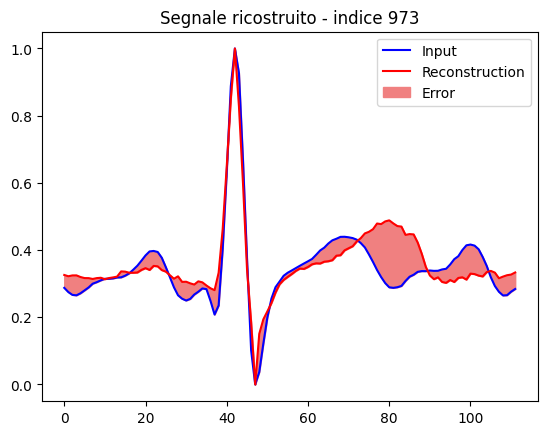

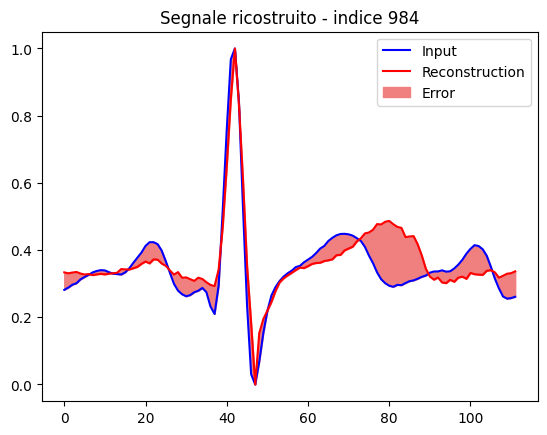

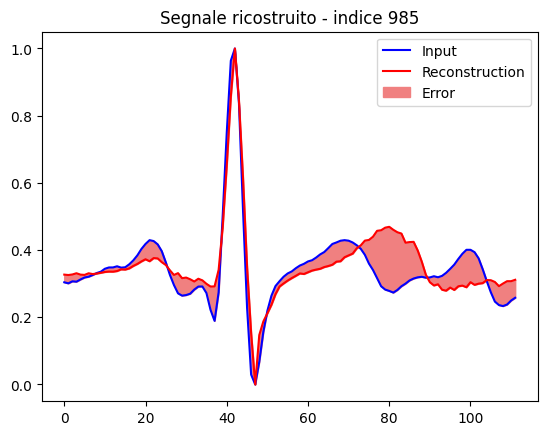

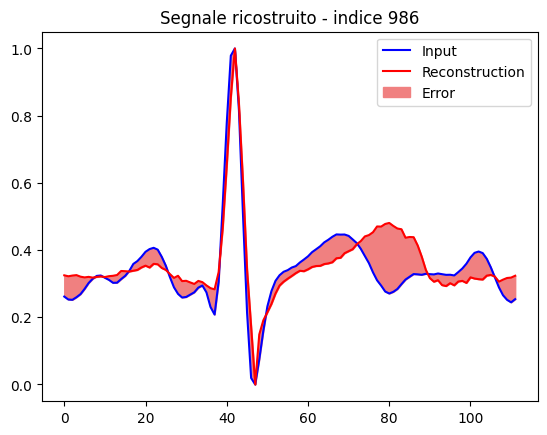

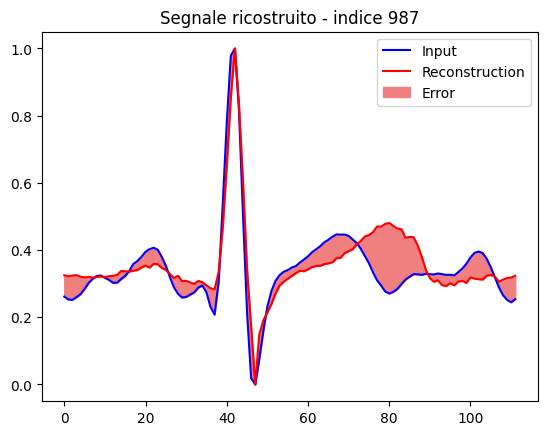

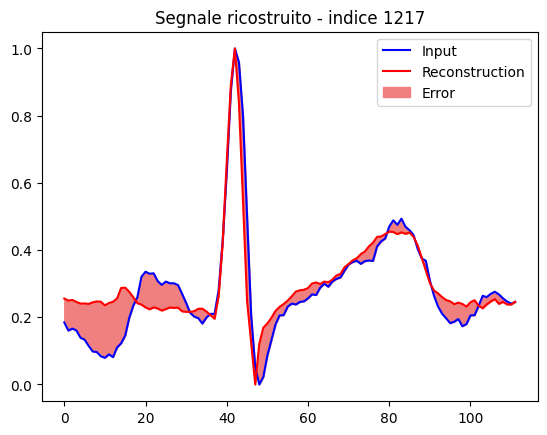

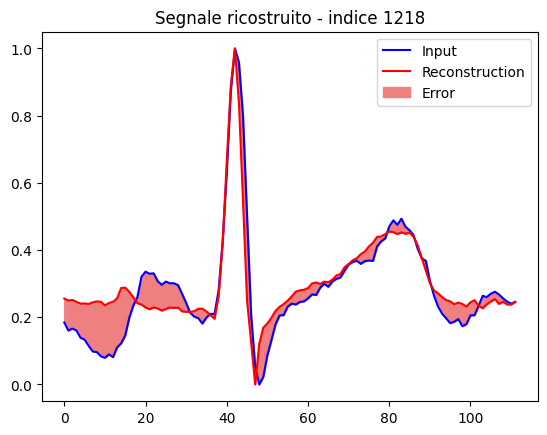

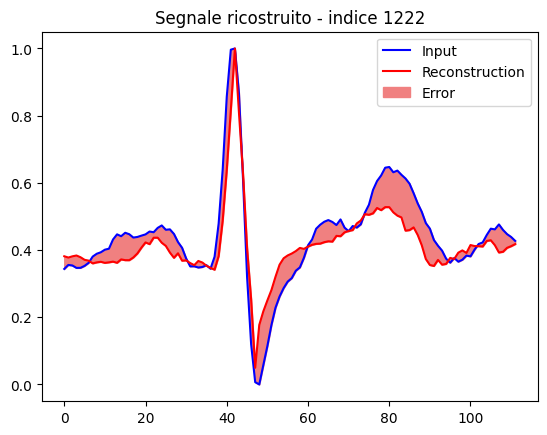

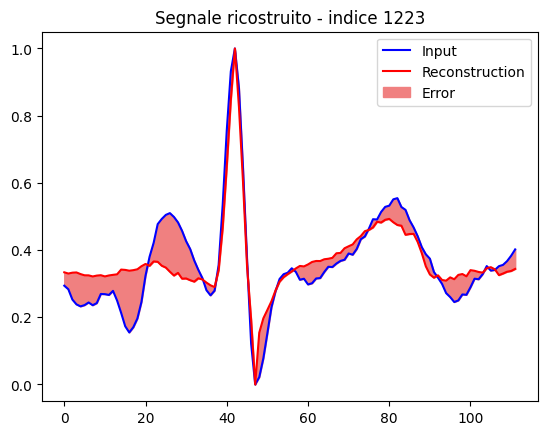

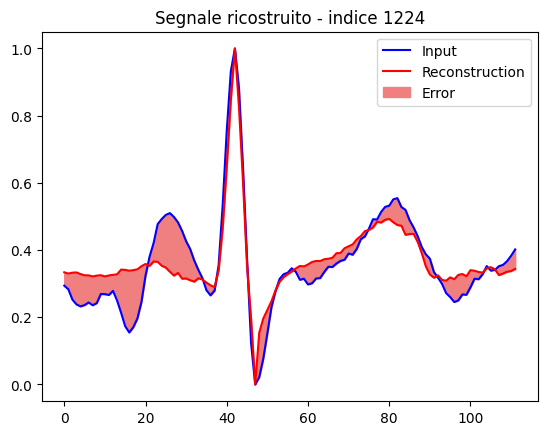

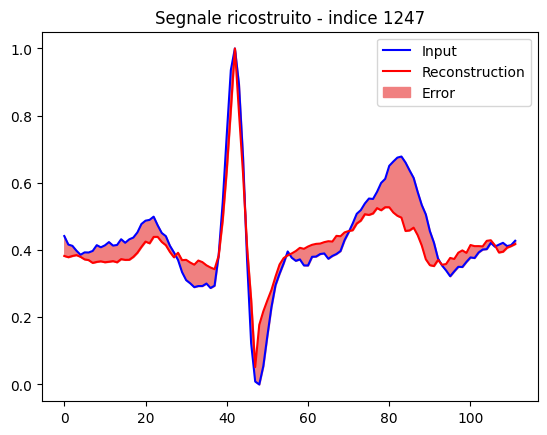

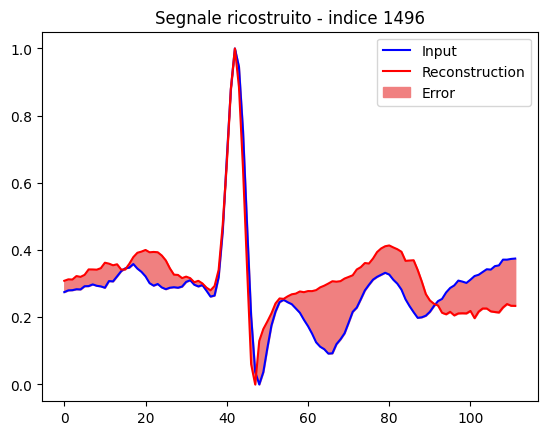

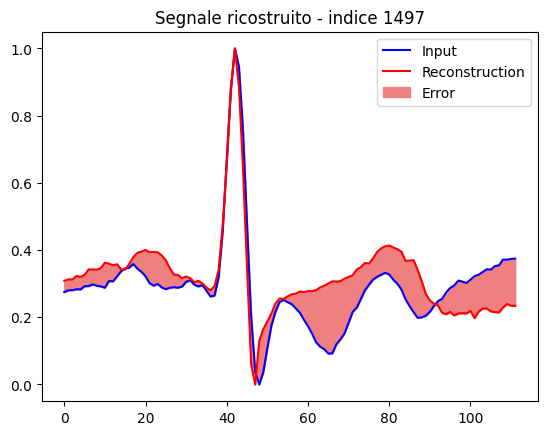

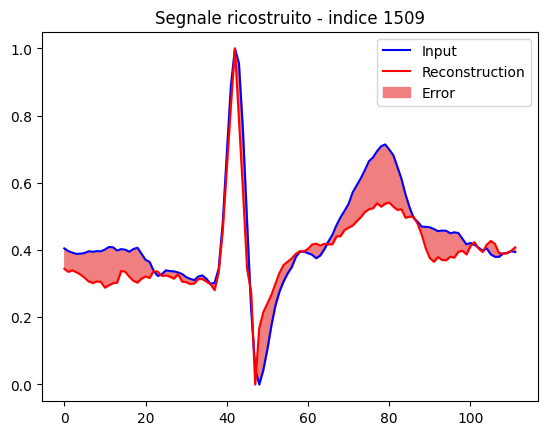

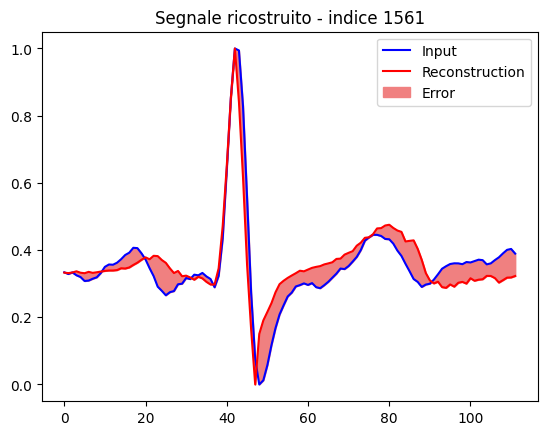

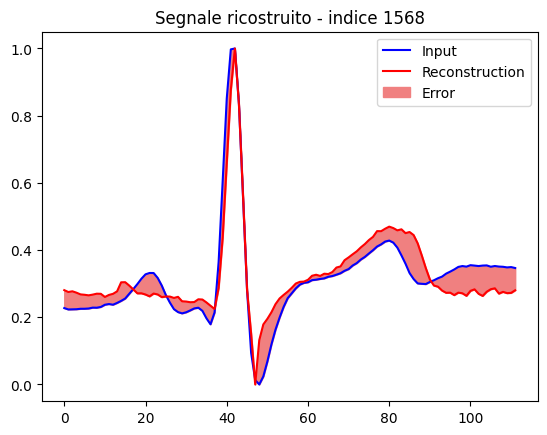

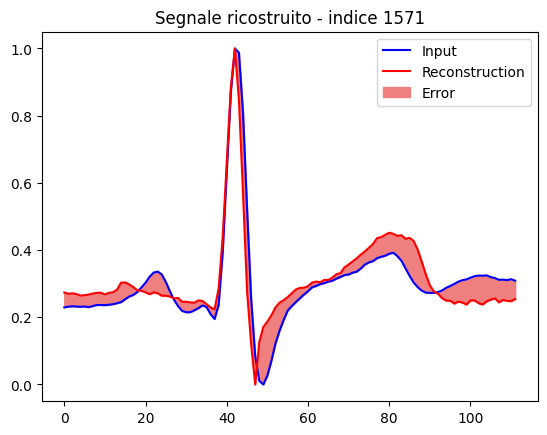

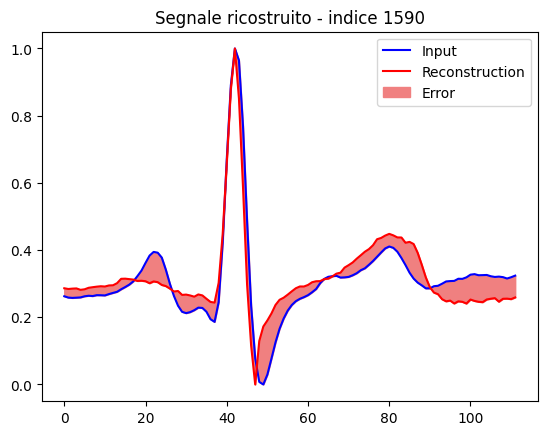

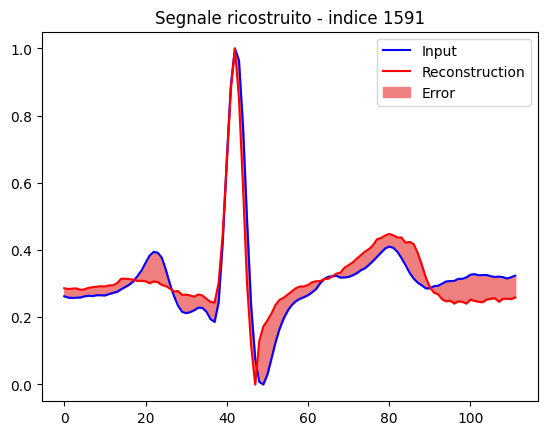

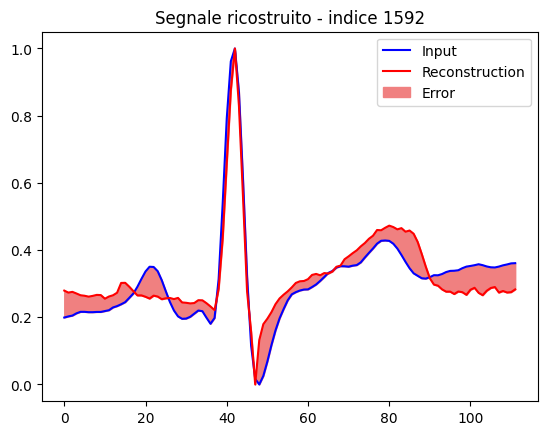

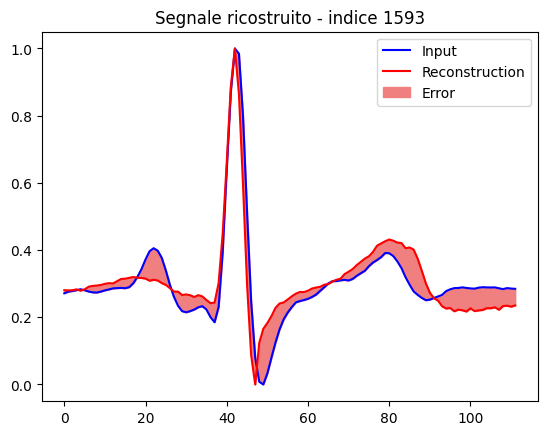

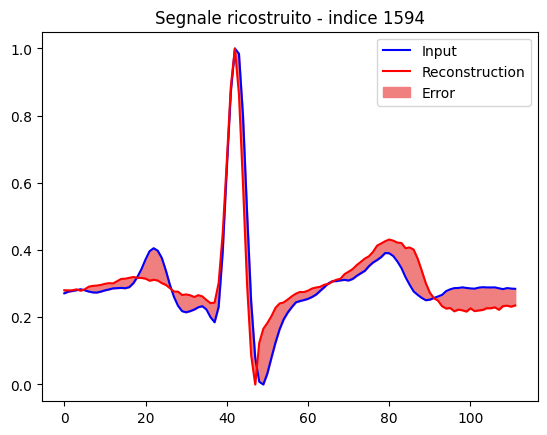

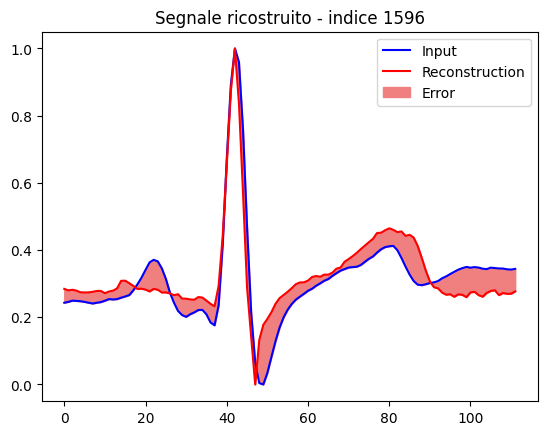

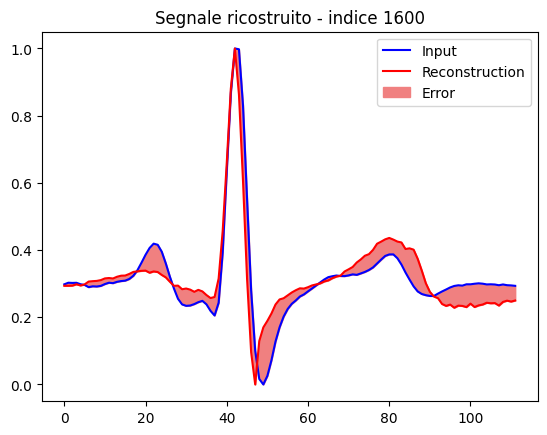

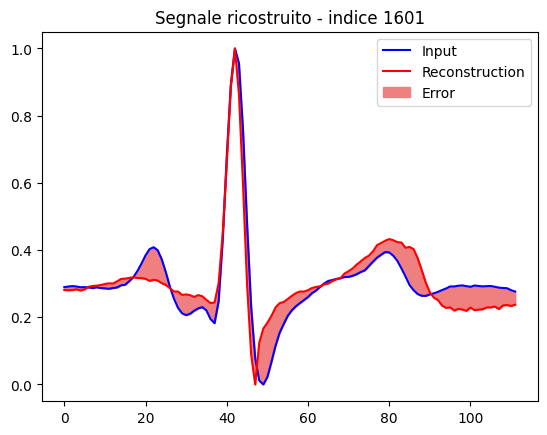

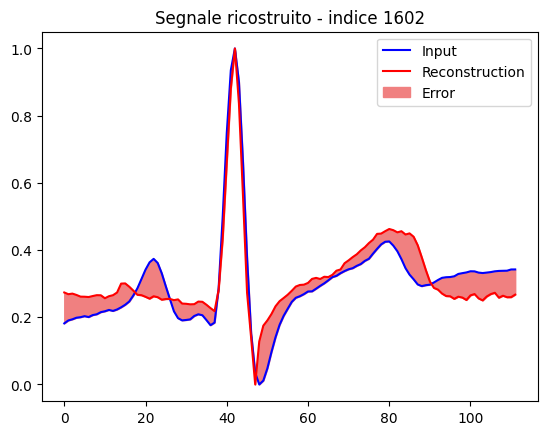

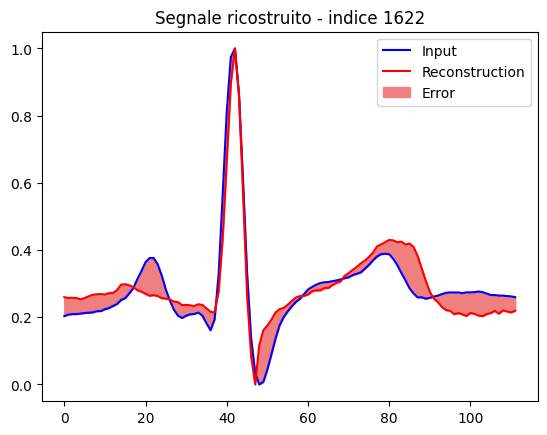

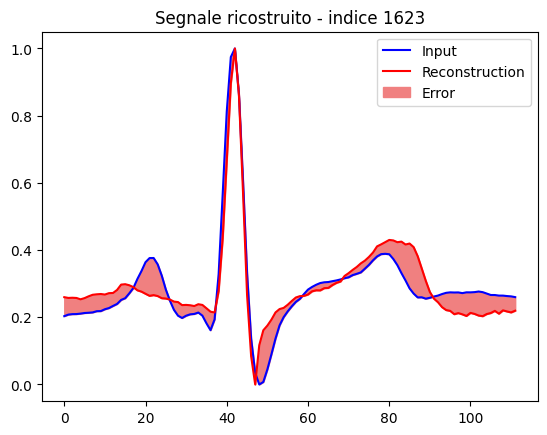

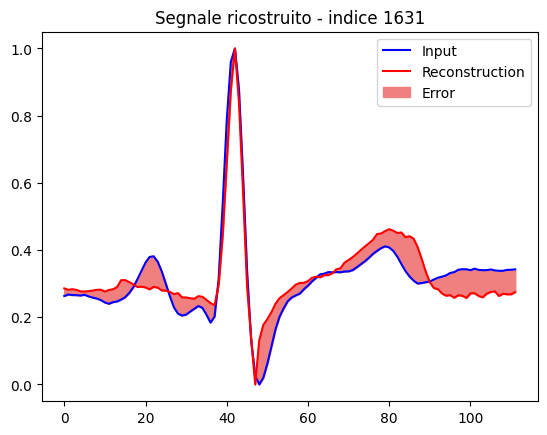

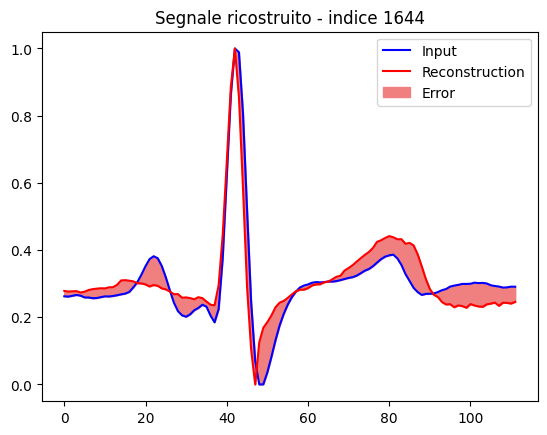

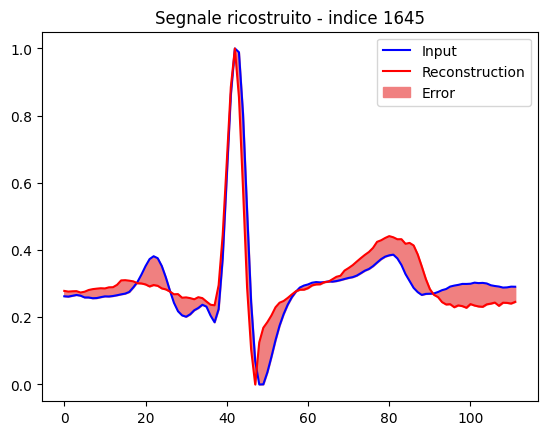

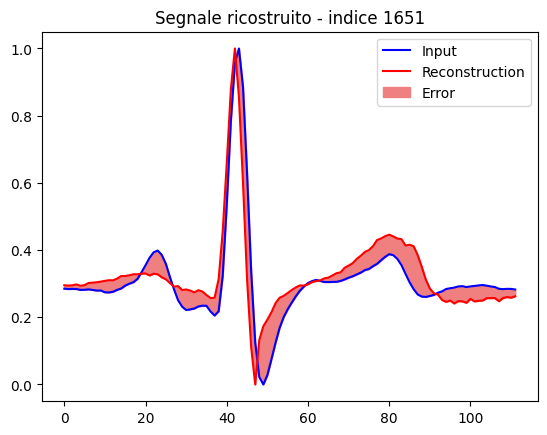

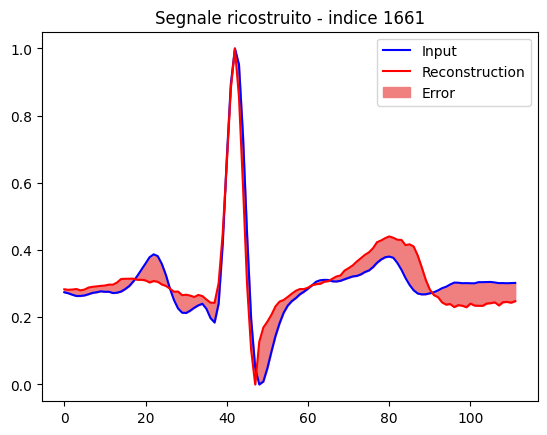

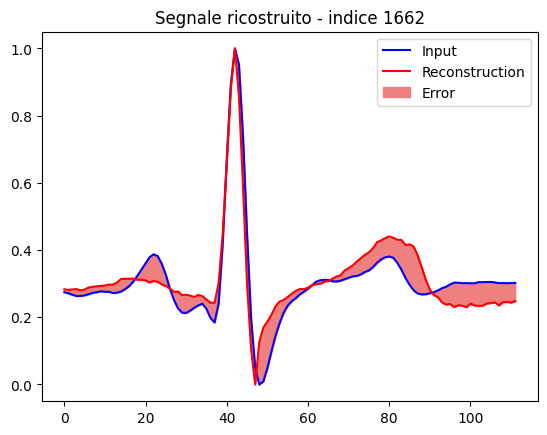

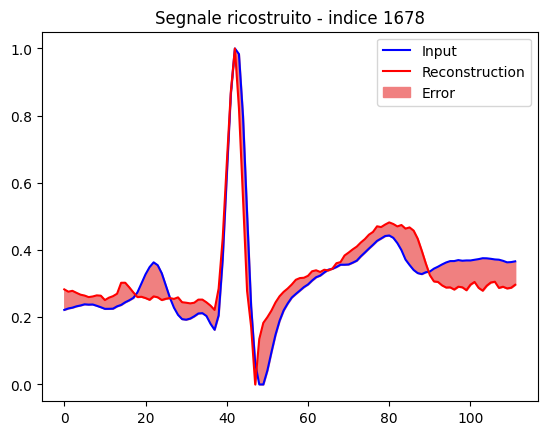

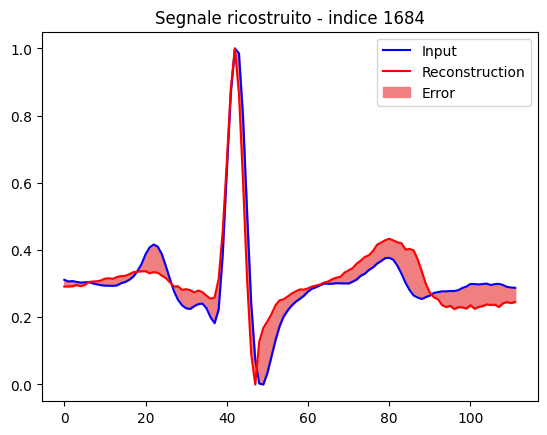

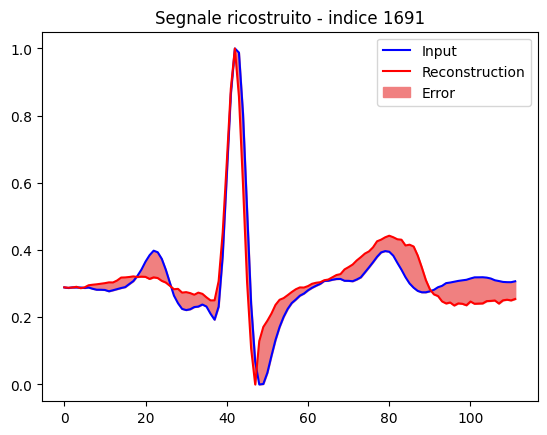

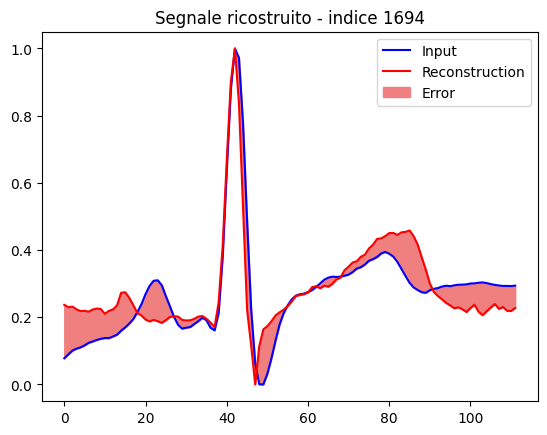

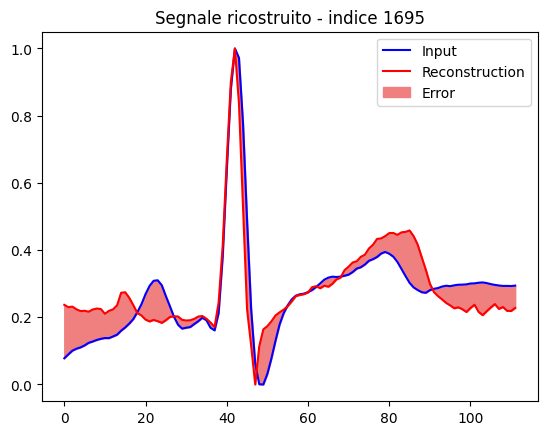

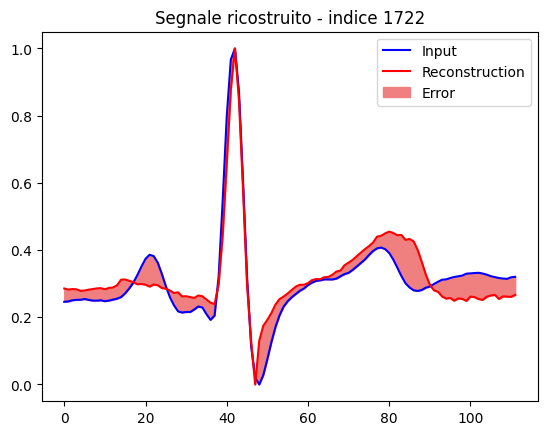

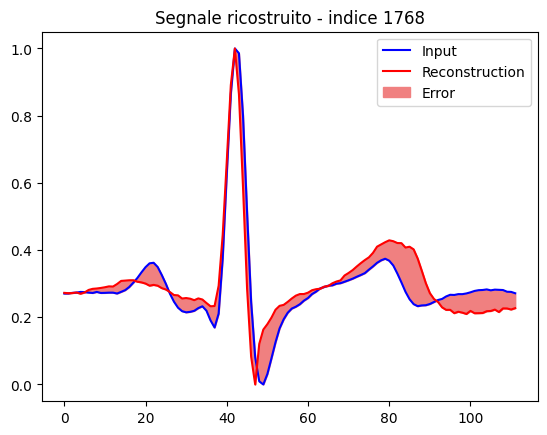

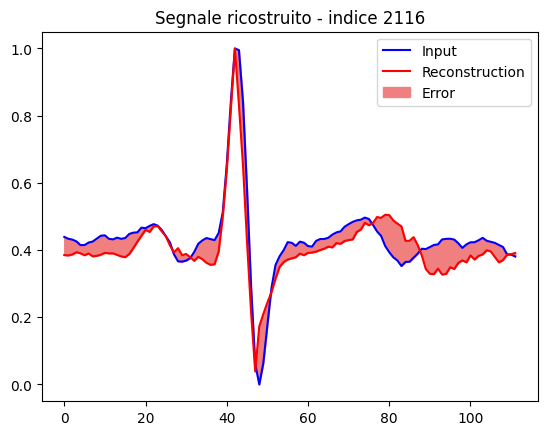

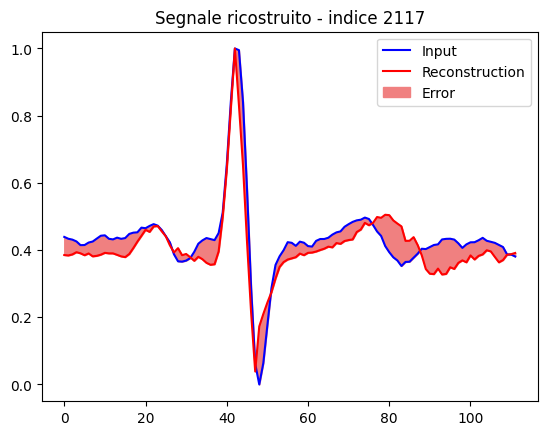

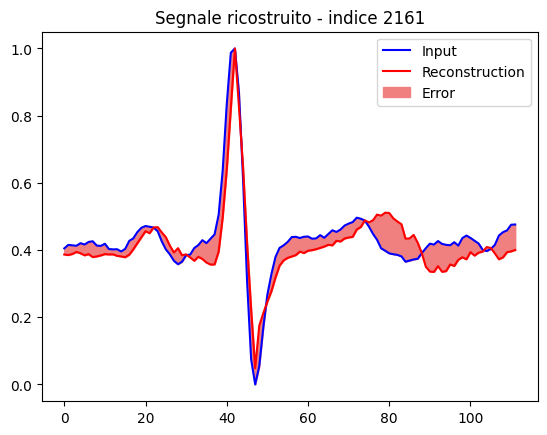

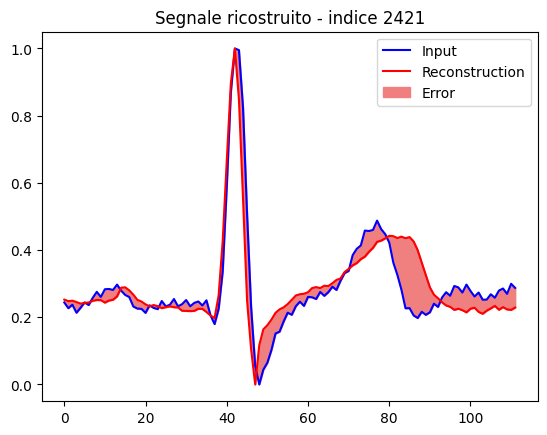

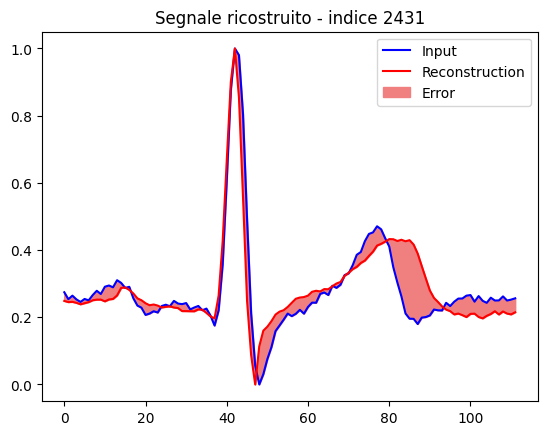

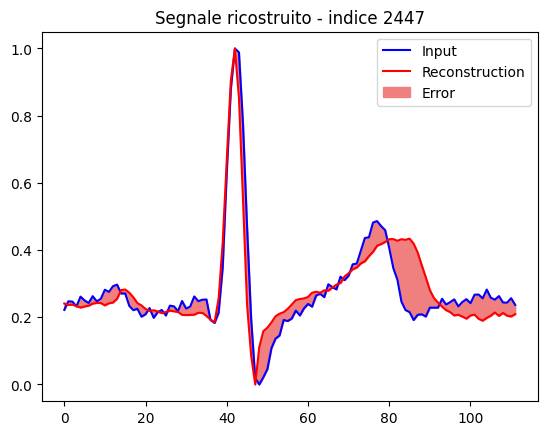

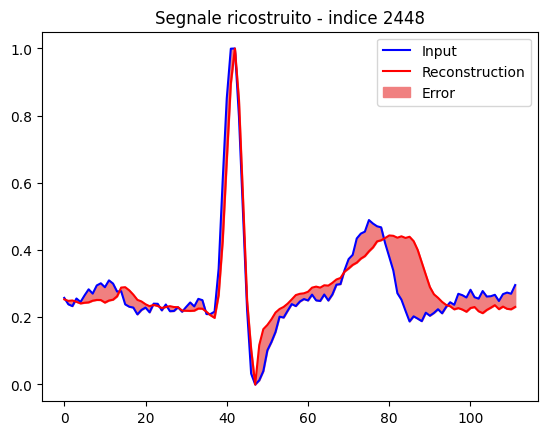

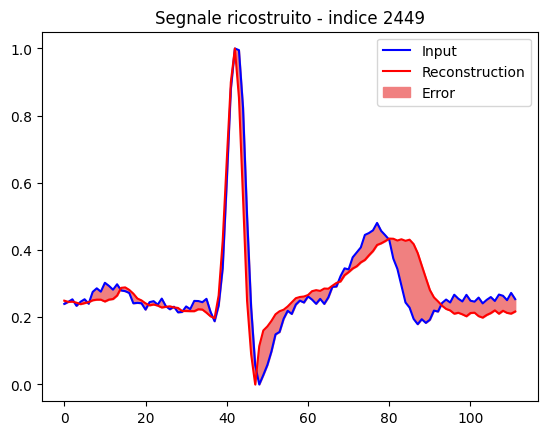

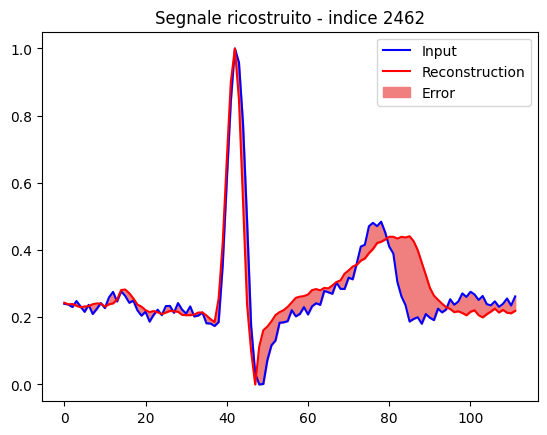

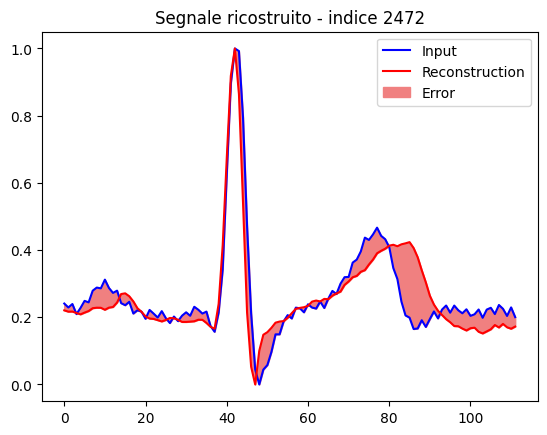

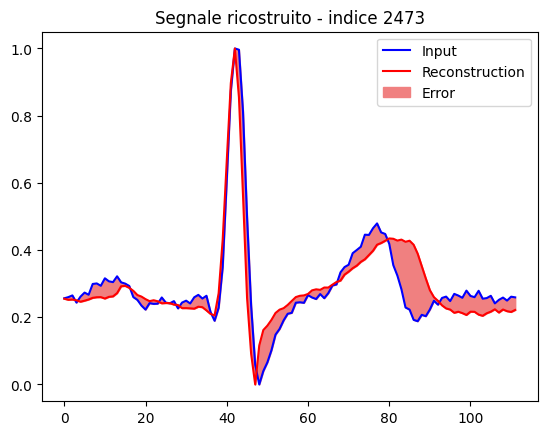

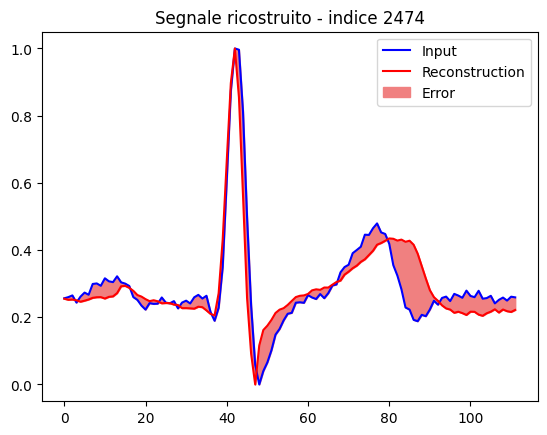

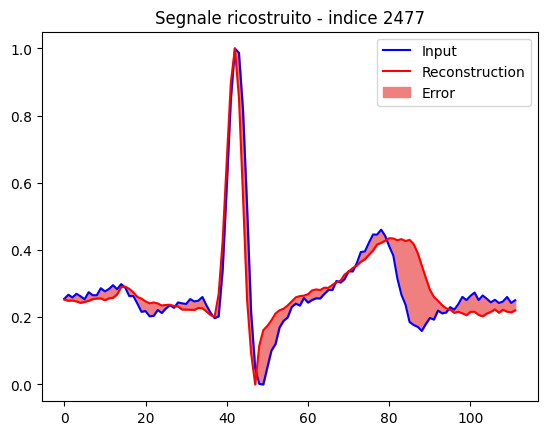

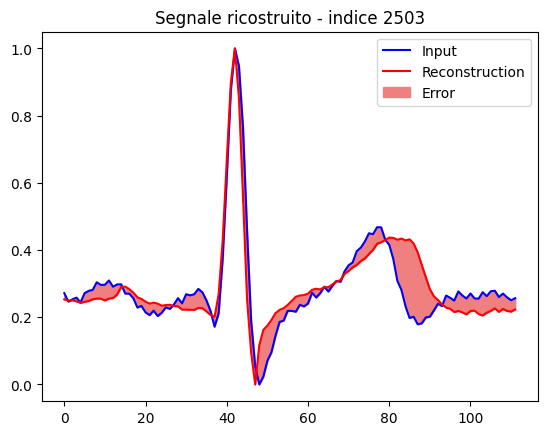

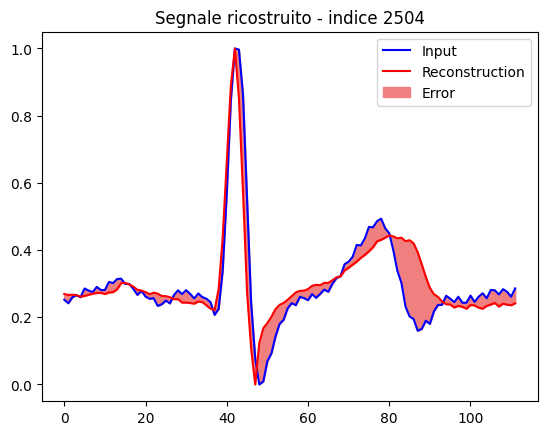

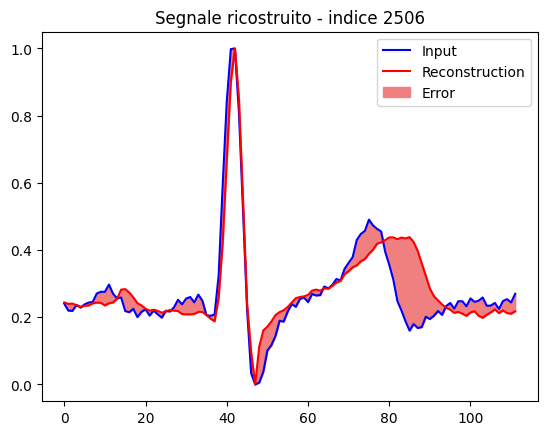

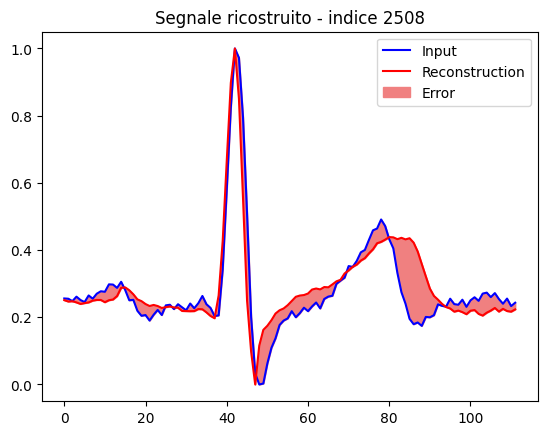

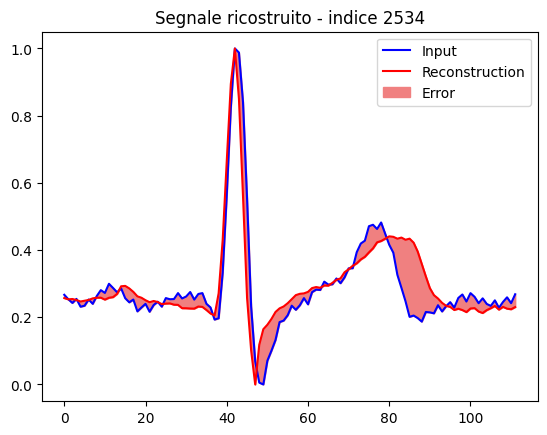

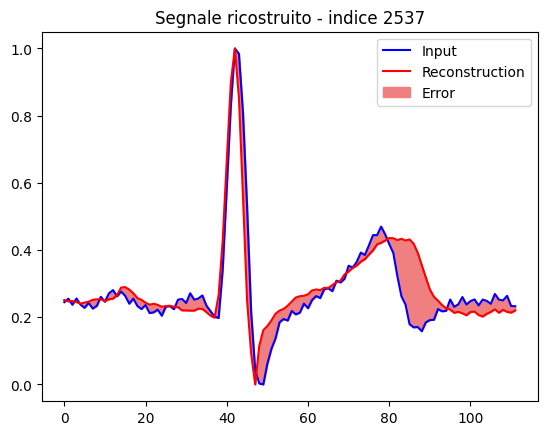

In [ ]:
def plot(data, n):
    dec_img = autoencoder(data)
    # dec_img = tf.squeeze(dec_img, axis=-1)
    plt.plot(data[n], 'b')
    plt.plot(dec_img[n], 'r')
    plt.fill_between(np.arange(data.shape[1]), data[n], dec_img[n], color='lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.title(f"Segnale ricostruito - indice {n}")
    plt.show()

for i in anomalous_indices:
  plot(x_test, i)

## Analisi Segnali (scegliendo compromesso)

In [ ]:
threshold = thresholds['Punto più vicino a (0,1)']['threshold']
test_loss = tf.reduce_mean(tf.abs(autoencoder(x_test) - x_test), axis=1).numpy()
anomalous_indices = np.where(test_loss >= threshold)[0]
print(f"Elementi sopra la soglia: {len(anomalous_indices)} su {len(x_test)}")
print(f"Percentuale: {len(anomalous_indices) / len(x_test) * 100:.2f}%")
print(anomalous_indices)

Elementi sopra la soglia: 25 su 2541
Percentuale: 0.98%
[ 141  441  618  930  931  942  943  986  987 1217 1218 1222 1223 1224
 1247 1496 1497 1509 1592 1596 1602 1651 1678 1694 1695]


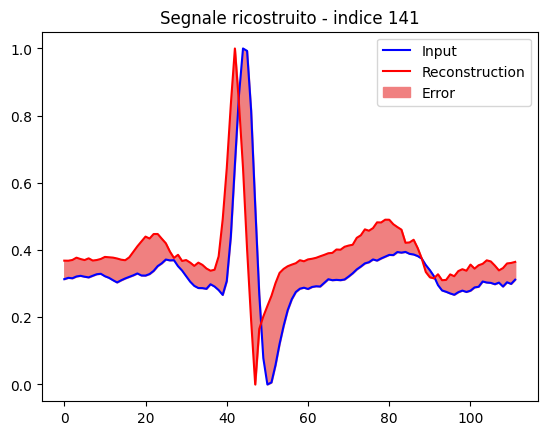

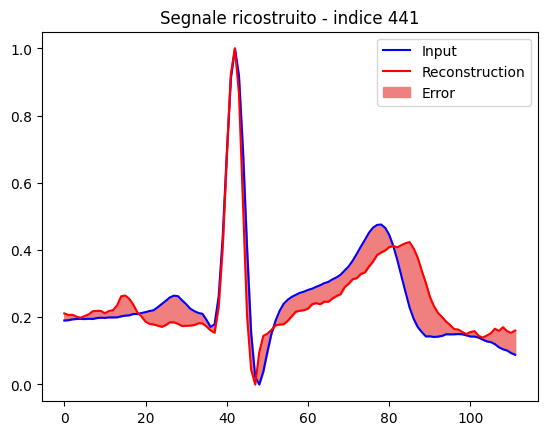

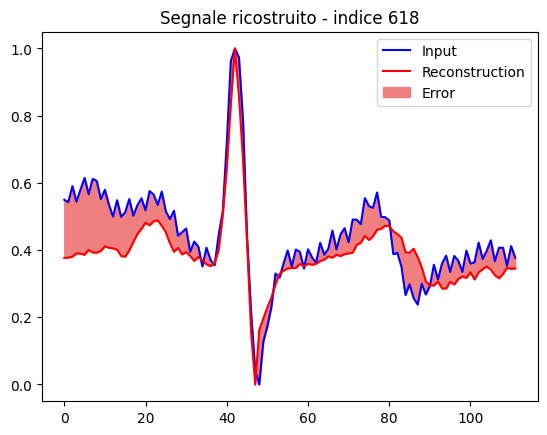

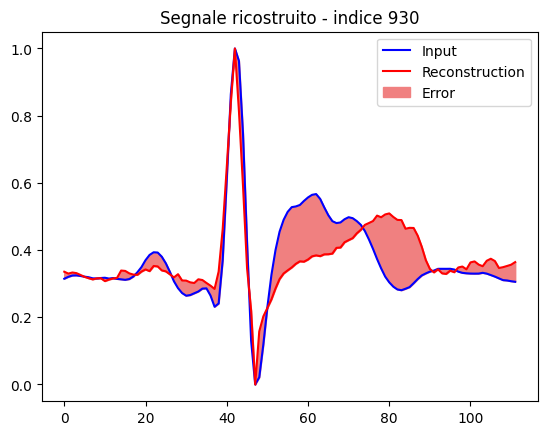

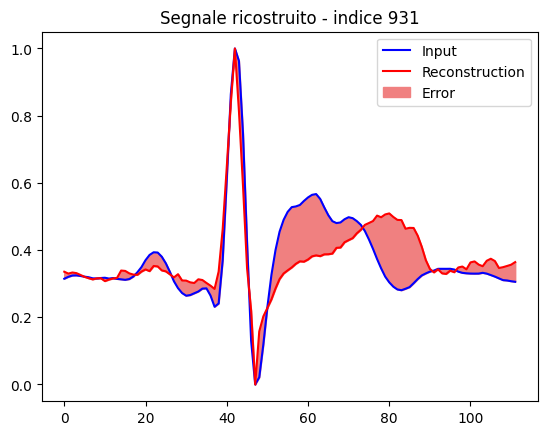

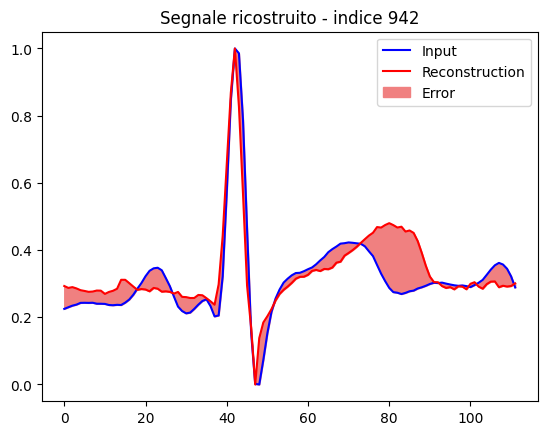

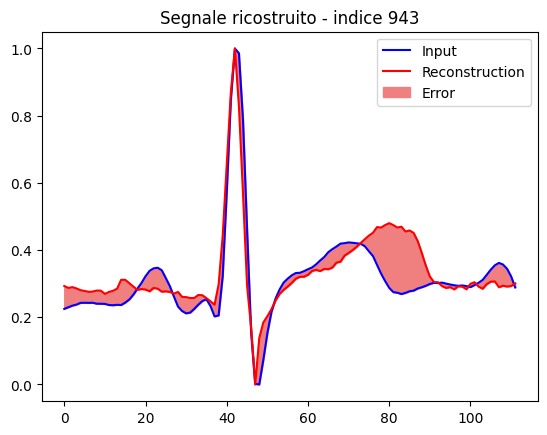

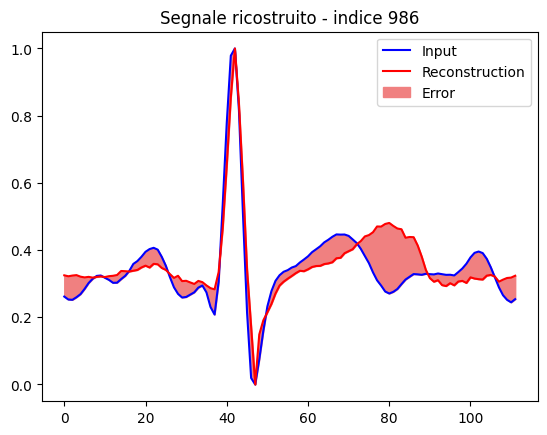

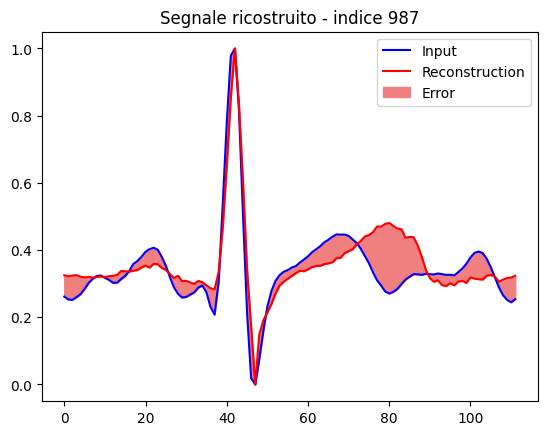

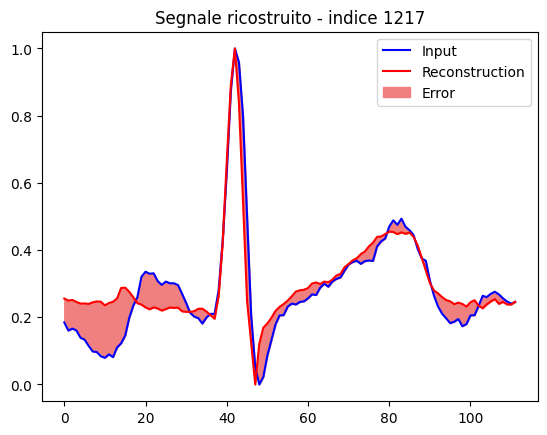

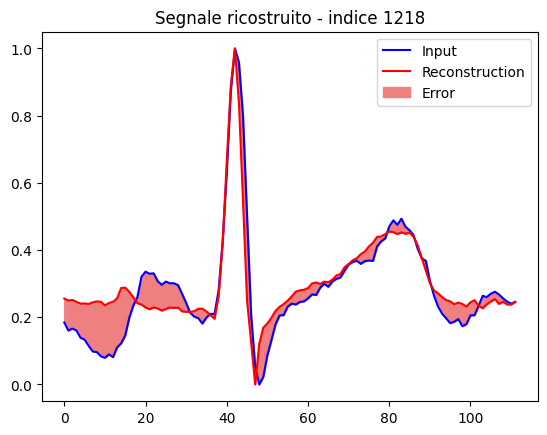

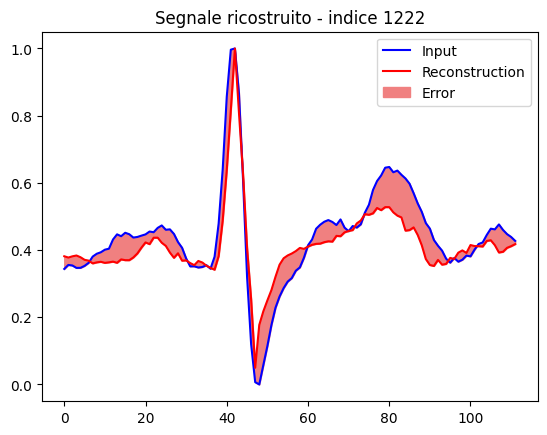

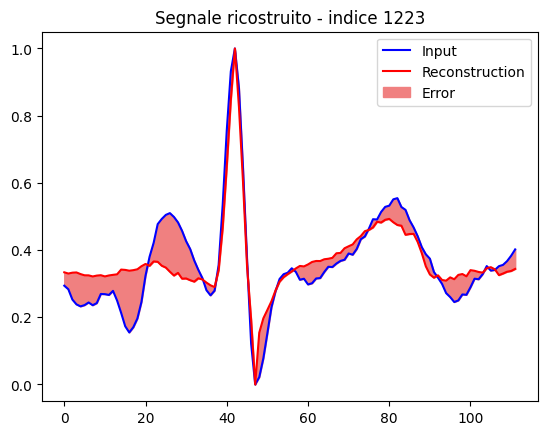

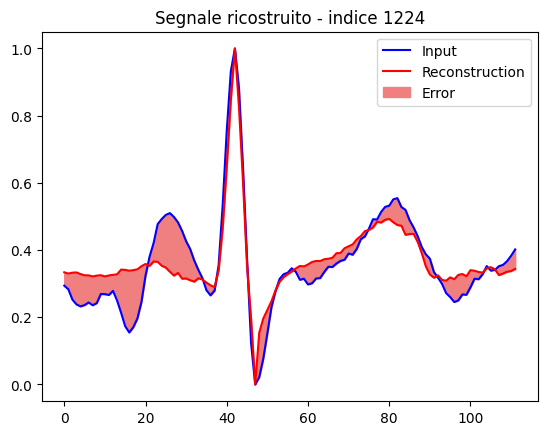

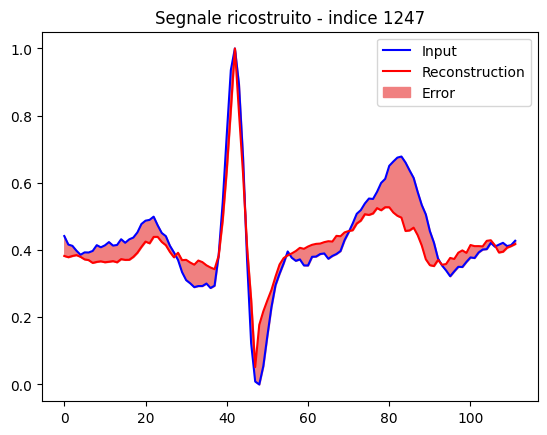

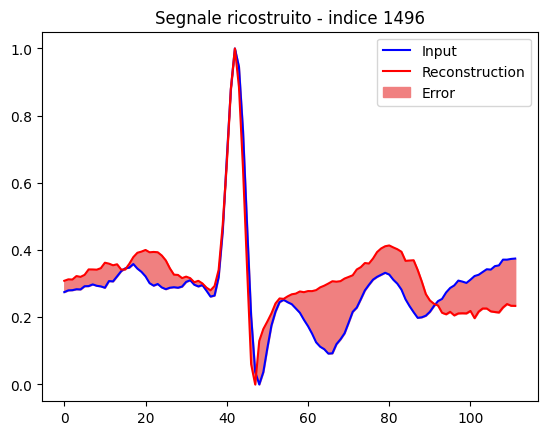

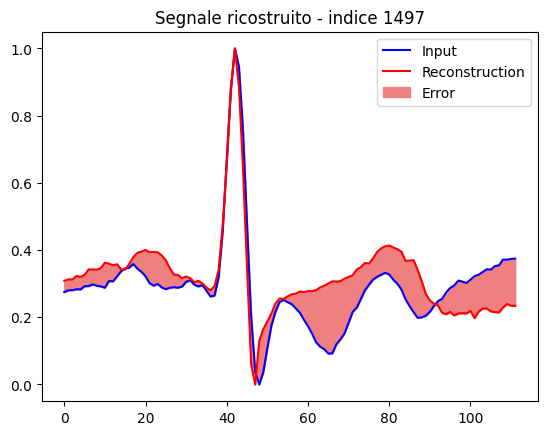

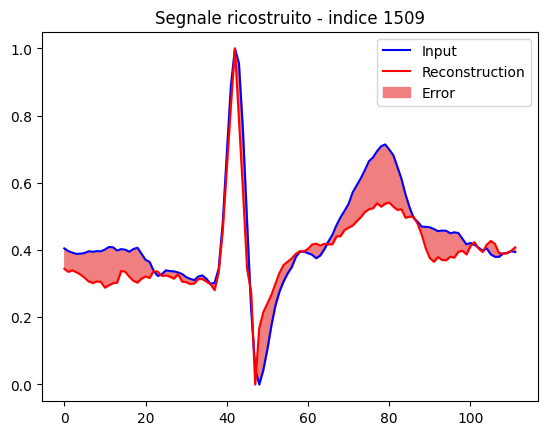

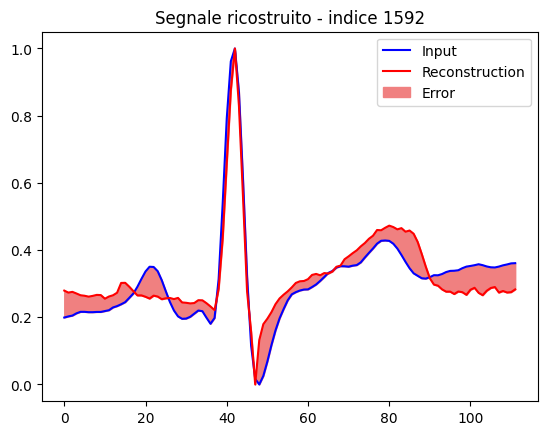

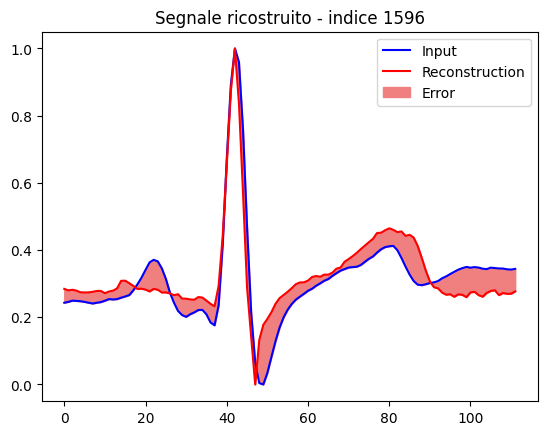

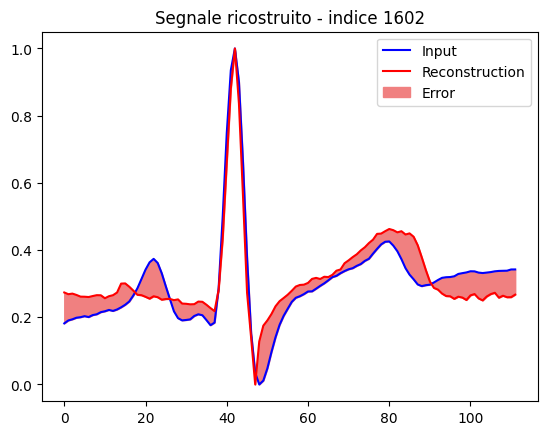

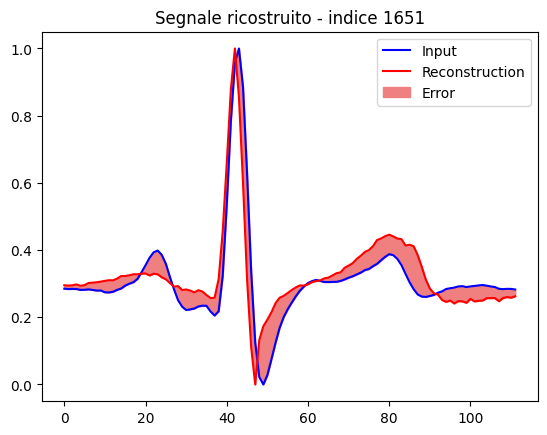

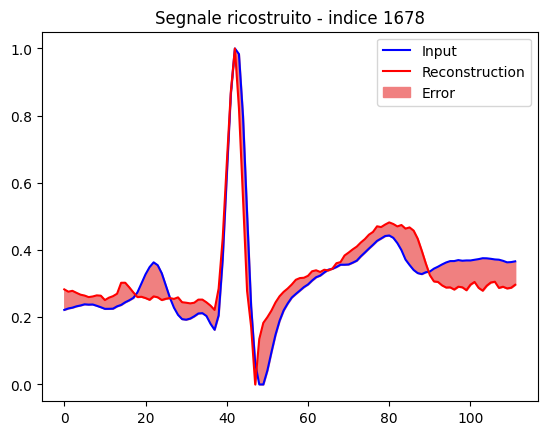

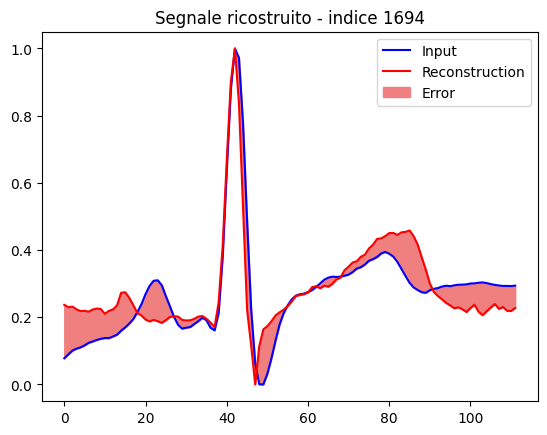

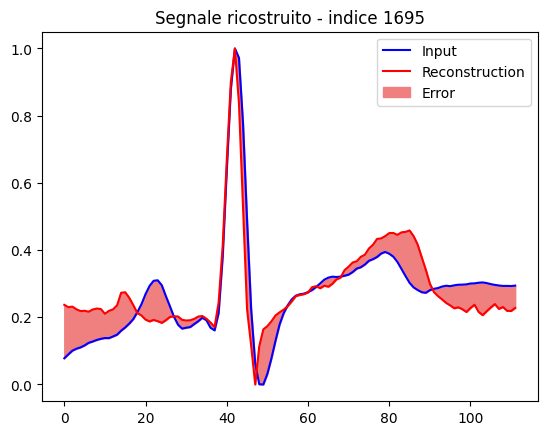

In [ ]:
for i in anomalous_indices:
  plot(x_test, i)

## Analisi Anomalie

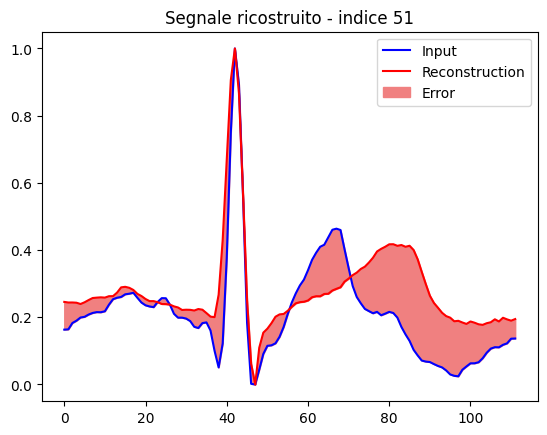

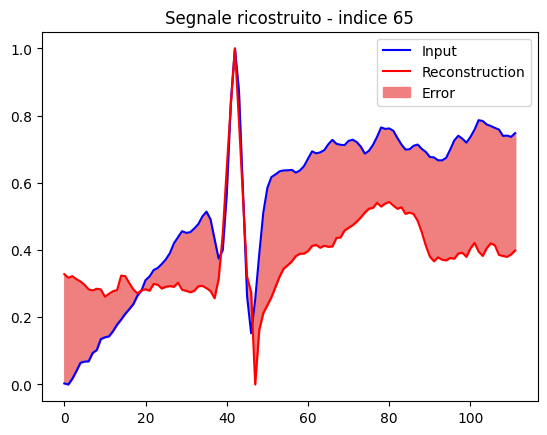

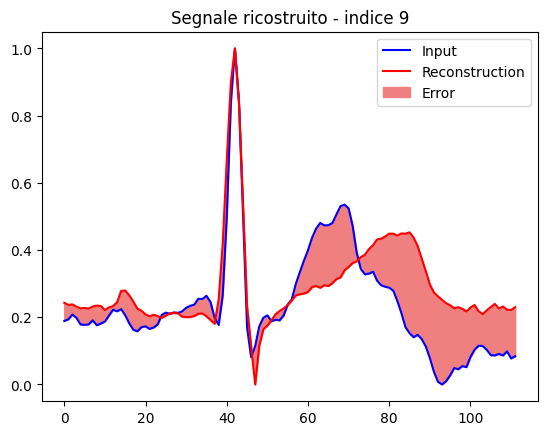

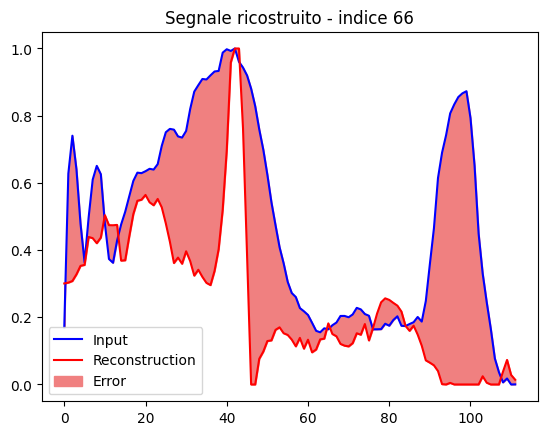

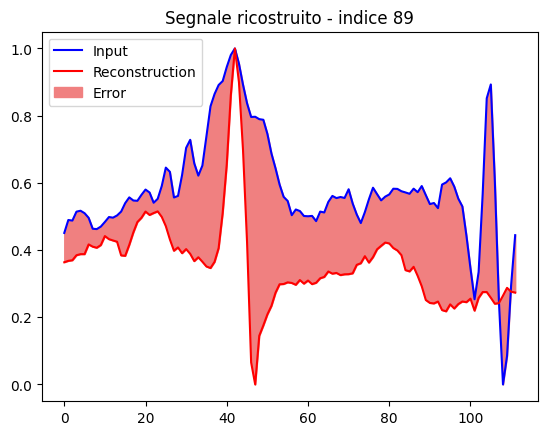

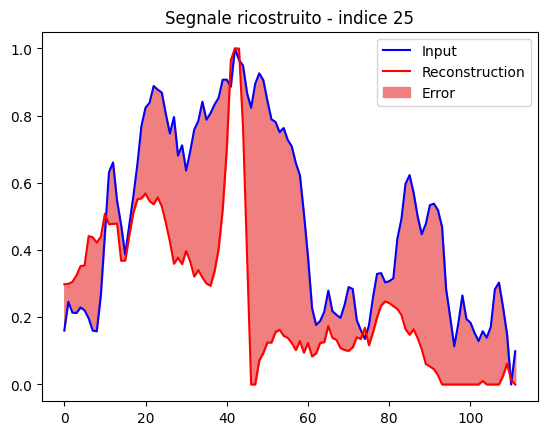

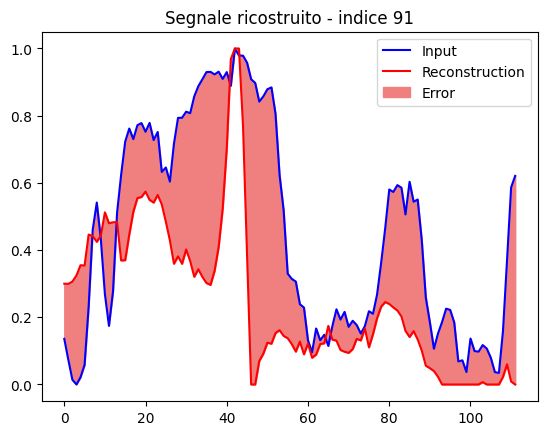

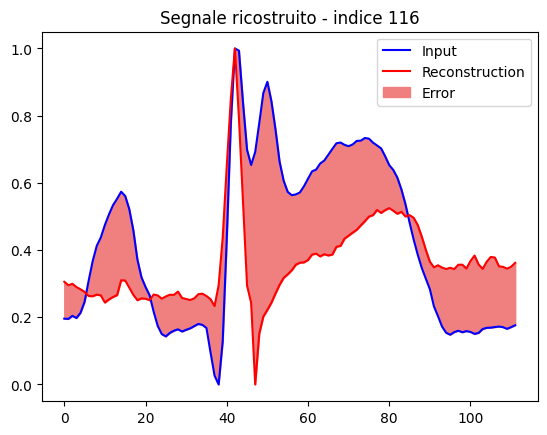

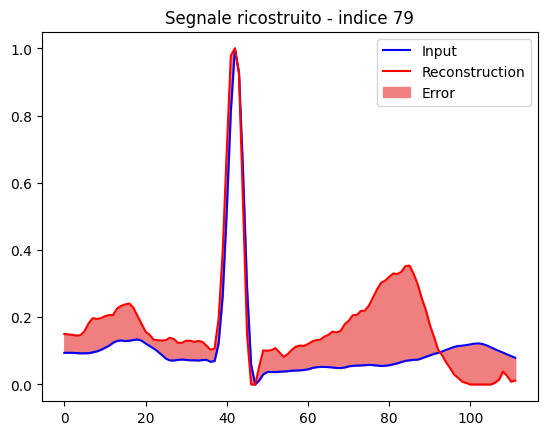

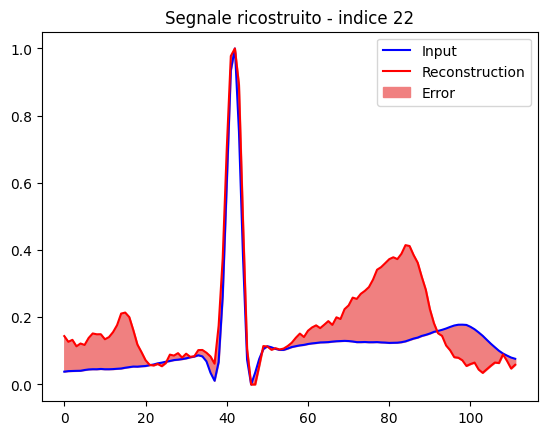

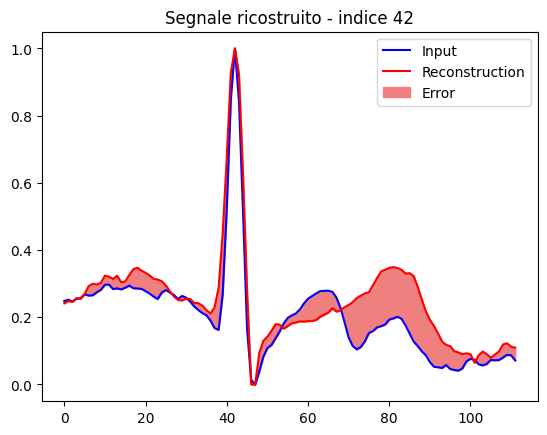

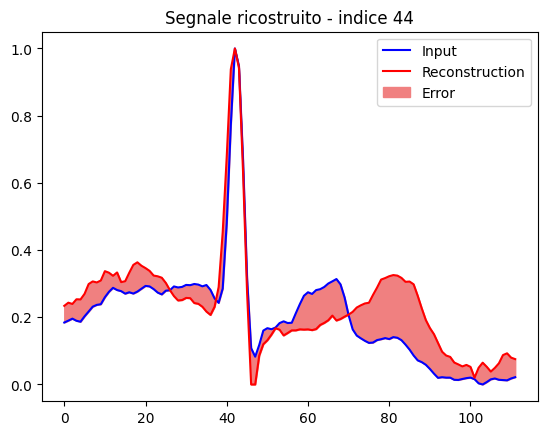

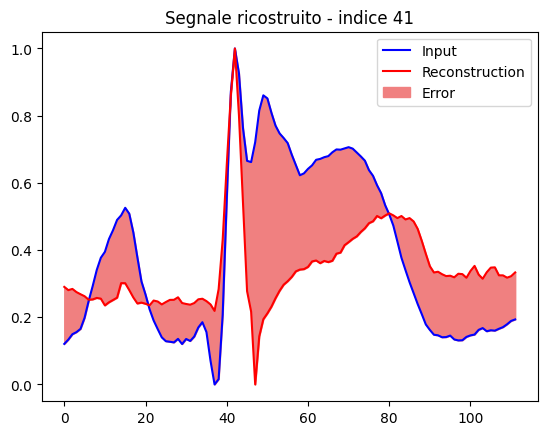

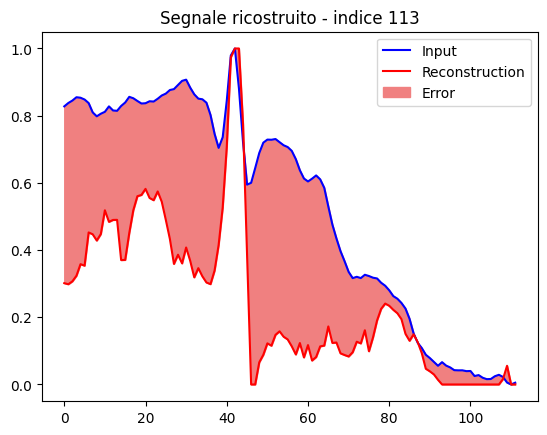

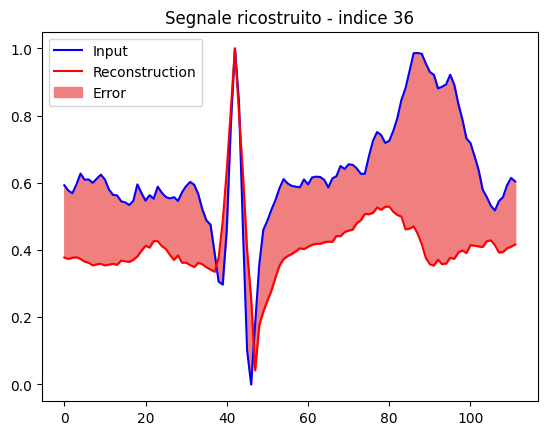

In [ ]:
random_indices_anomaly = random.sample(range(x_anomaly.shape[0]), 15)
for i in random_indices_anomaly:
  plot(x_anomaly, i)

## Pruning

Come abbiamo potuto notare dalle celle precedenti, il modello offre buoni risultati ma con un costo computazione non bassissimo (ma comunque accettabile con i microcontrollori con FPU nel mercato di oggi). Tuttavia, è stato individuato che nel modello molti pesi risultano vicini allo zero e, dunque, ininfluenti ai fini della combinazione per l'output di quel preciso neurone. Una possibile soluzione è quella di rimuovere questi pesi (Pruning, ponendoli a zero) e così da diminuire il numero di operazioni e calcoli da effettuare.

In [ ]:
from tensorflow.keras.losses import MeanAbsoluteError

def manual_prune_model(model, threshold=0.05):
    total_weights = 0
    total_kept = 0

    def prune_layer(layer):
        nonlocal total_weights, total_kept

        if isinstance(layer, (tf.keras.Model, tf.keras.Sequential)):
            for sub_layer in layer.layers:
                prune_layer(sub_layer)

        elif isinstance(layer, tf.keras.layers.Dense):
            w, b = layer.get_weights()
            mask = np.abs(w) >= threshold
            w_pruned = w * mask
            layer.set_weights([w_pruned, b])

            kept = np.sum(mask)
            total = w.size
            pruned = total - kept

            total_weights += total
            total_kept += kept

            print(f"[{model.name}] {layer.name}:")
            print(f"  → Pesi mantenuti : {kept}")
            print(f"  → Pesi tagliati  : {pruned}")
            print(f"  → Totale pesi    : {total}\n")

    prune_layer(model)
    pruned_total = total_weights - total_kept
    print("=== RIEPILOGO FINALE ===")
    print(f"Totale pesi       : {total_weights}")
    print(f"Pesi mantenuti    : {total_kept}")
    print(f"Pesi tagliati     : {pruned_total}")
    print(f"Sparsità globale  : {pruned_total / total_weights:.2%}")

def print_dense_weight_percentile(model, percentile=30):
    all_weights = []
    def collect_weights(m):
        for layer in m.layers:
            if isinstance(layer, (tf.keras.Model, tf.keras.Sequential)):
                collect_weights(layer)
            elif isinstance(layer, tf.keras.layers.Dense):
                w, _ = layer.get_weights()
                all_weights.append(np.abs(w).flatten())
    collect_weights(model)
    if all_weights:
        flat_weights = np.concatenate(all_weights)
        flat_weights.sort()
        perc_val = np.percentile(flat_weights, percentile)
        print(f"{percentile}° percentile dei pesi assoluti: {perc_val:.8f}")
        return perc_val
    else:
        print("Nessun layer Dense trovato.")

def plot_anomaly(data, n):
  dec_img = autoencoder_copy(data)
  #dec_img = tf.squeeze(dec_img, axis=-1)
  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(data.shape[1]), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

In [ ]:
response = requests.get(url_tuned)
with open('autoencoder_tuned.weights.h5', 'wb') as f:
    f.write(response.content)
autoencoder_copy = Autoencoder(x_combined_train.shape[1], dropout=dropout)
autoencoder_copy(tf.zeros((1, x_combined_train.shape[1])))
autoencoder_copy.load_weights('autoencoder_tuned.weights.h5')
percentile_thresh = print_dense_weight_percentile(autoencoder, percentile=30)

30° percentile dei pesi assoluti: 0.08103395


E' stato scelta come soglia il 30esimo percentile come combinazione tra performances e costo computazionale

[ECG_Autoencoder] dense_66:
  → Pesi mantenuti : 590
  → Pesi tagliati  : 306
  → Totale pesi    : 896

[ECG_Autoencoder] dense_67:
  → Pesi mantenuti : 29
  → Pesi tagliati  : 3
  → Totale pesi    : 32

[ECG_Autoencoder] dense_68:
  → Pesi mantenuti : 7
  → Pesi tagliati  : 1
  → Totale pesi    : 8

[ECG_Autoencoder] dense_69:
  → Pesi mantenuti : 8
  → Pesi tagliati  : 0
  → Totale pesi    : 8

[ECG_Autoencoder] dense_70:
  → Pesi mantenuti : 28
  → Pesi tagliati  : 4
  → Totale pesi    : 32

[ECG_Autoencoder] dense_71:
  → Pesi mantenuti : 648
  → Pesi tagliati  : 248
  → Totale pesi    : 896

=== RIEPILOGO FINALE ===
Totale pesi       : 1872
Pesi mantenuti    : 1310
Pesi tagliati     : 562
Sparsità globale  : 30.02%
MAE post-pruning: 0.03081005
MAE pre-pruning: 0.027001858


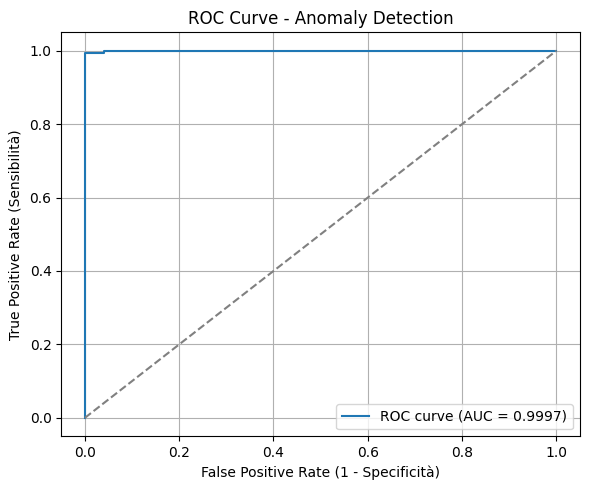


=== Massima Sensibilità (max TPR) ===
Soglia: 0.050278
True Positive Rate (Sensibilità): 1.0000
False Positive Rate: 0.0400
Accuracy: 0.9890


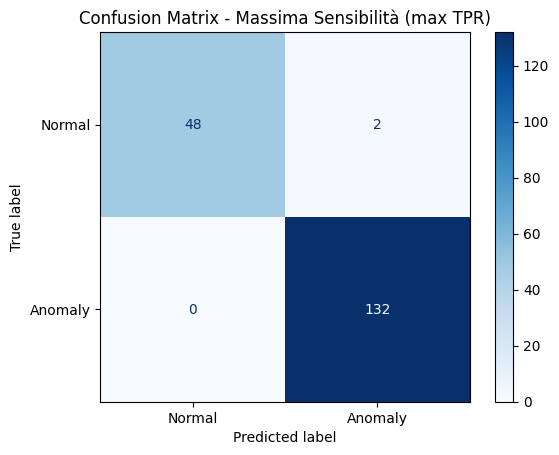


=== Minimo FPR (max Specificità) ===
Soglia: inf
True Positive Rate (Sensibilità): 0.0000
False Positive Rate: 0.0000
Accuracy: 0.2747


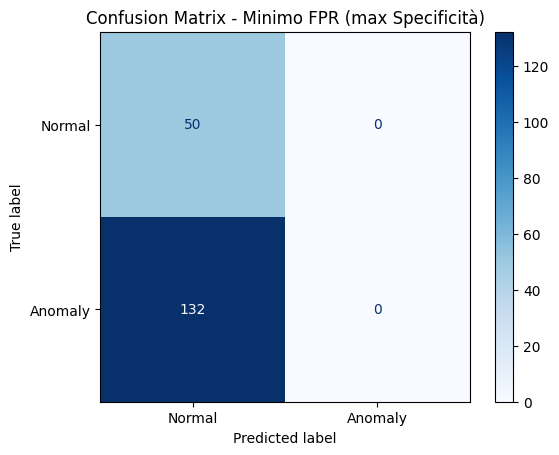


=== Punto più vicino a (0,1) ===
Soglia: 0.053628
True Positive Rate (Sensibilità): 0.9924
False Positive Rate: 0.0000
Accuracy: 0.9945


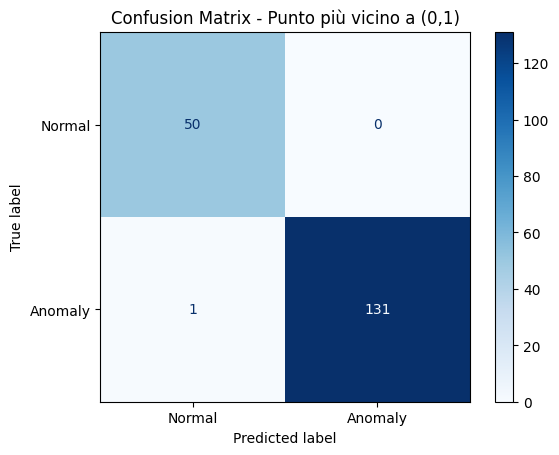

{'Massima Sensibilità (max TPR)': {'threshold': np.float32(0.050277848),
  'TPR': np.float64(1.0),
  'FPR': np.float64(0.04),
  'accuracy': 0.989010989010989},
 'Minimo FPR (max Specificità)': {'threshold': np.float32(inf),
  'TPR': np.float64(0.0),
  'FPR': np.float64(0.0),
  'accuracy': 0.27472527472527475},
 'Punto più vicino a (0,1)': {'threshold': np.float32(0.053628393),
  'TPR': np.float64(0.9924242424242424),
  'FPR': np.float64(0.0),
  'accuracy': 0.9945054945054945}}

In [ ]:
manual_prune_model(autoencoder_copy, threshold=percentile_thresh)
mae = MeanAbsoluteError()
print("MAE post-pruning:", mae(x_combined_train, autoencoder_copy(x_combined_train)).numpy())
print("MAE pre-pruning:", mae(x_combined_train, autoencoder(x_combined_train)).numpy())
evaluate_thresholds(autoencoder_copy, x_combined_val, x_anomaly)

Le performances risultano estremamente simili nonostante il taglio di un bel 30% dei pesi, lascianod buoni spiragli per il futuro. Tuttavia, è sempre bene considerare che tali test dovrebbero essere eseguiti su ampia scala e con più persone ed anomalie oltre che anomalie individuate con lo stesso strumento usato in questa tesi. Come riportato di seguito, il taglio dei pesi rende le funzioni ricostruite meno continue, tuttavia si adatta comunque all'input che riceve, dimostrando che l'individuazione importante delle features era comunque individuata.

Qual è il problema del Pruning? Serve customizzare i neuroni lato micro per indicare che alcune operazione dovrebbero essere ignorate. Fattibile, ma è necessario customizzare ogni volta quali neuroni ignorare rendendo il modello non di facile esportazione sul micro (i.e. non possiamo subito esportare i pesi del modello ed eseguirlo, serve indicare quali neuroni mascherare anche)

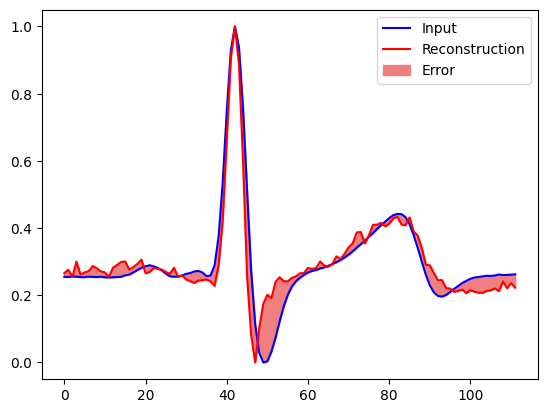

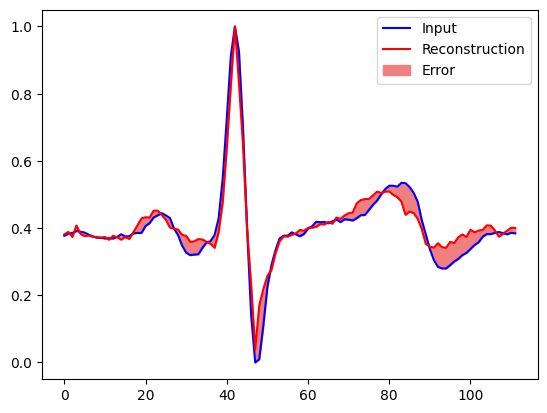

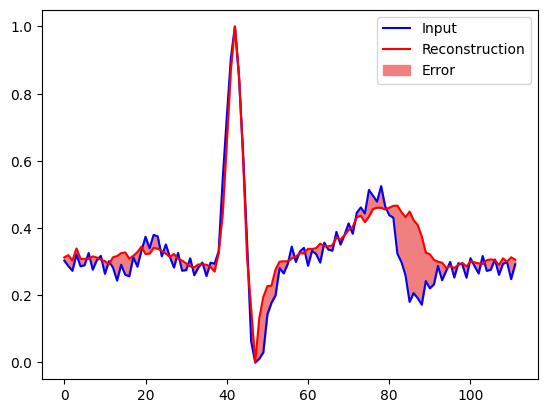

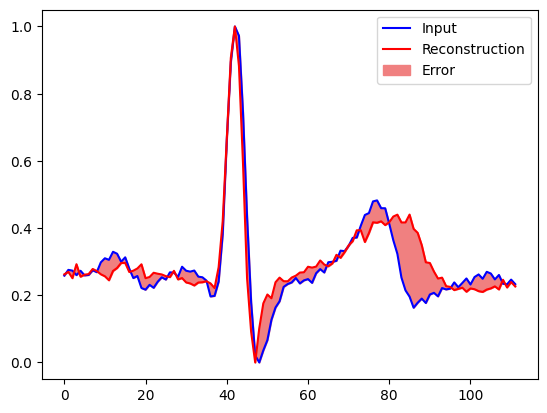

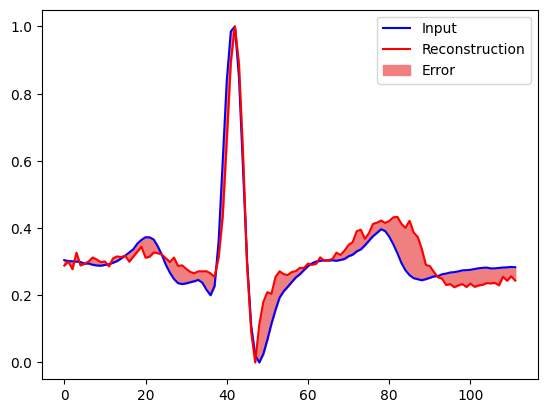

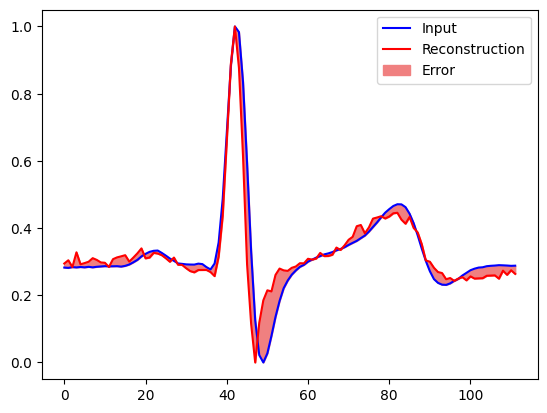

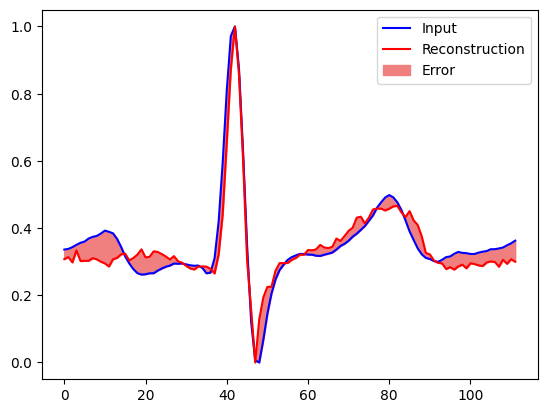

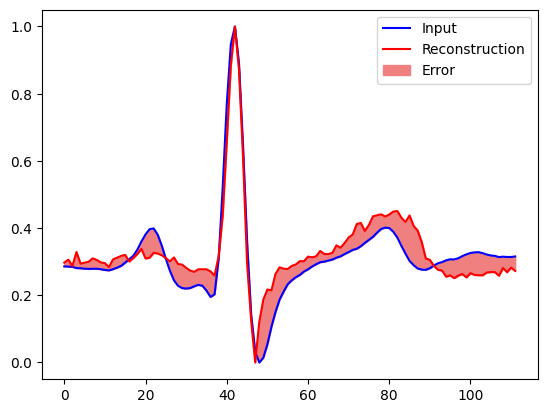

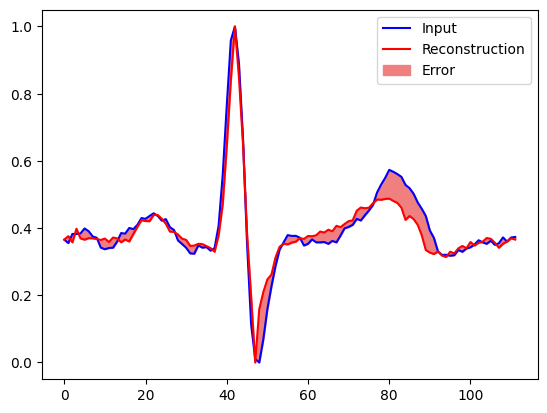

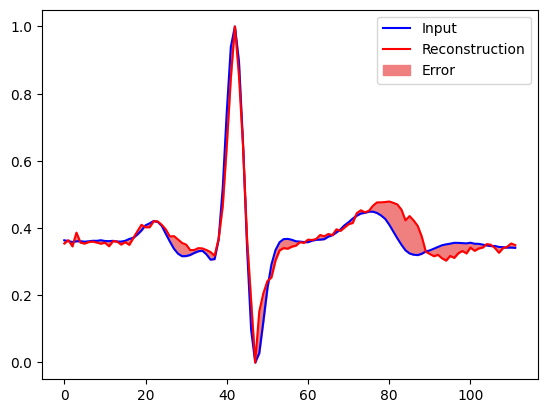

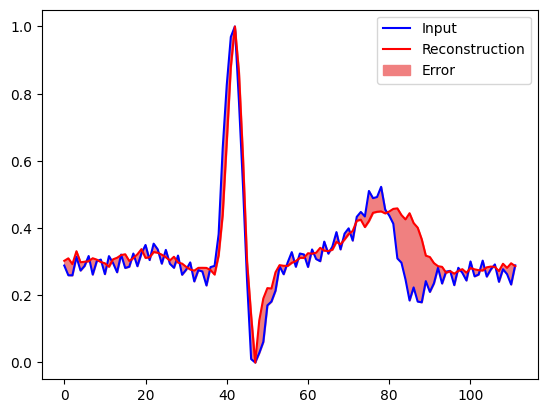

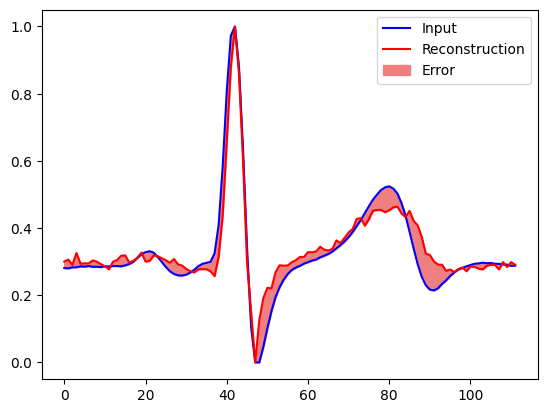

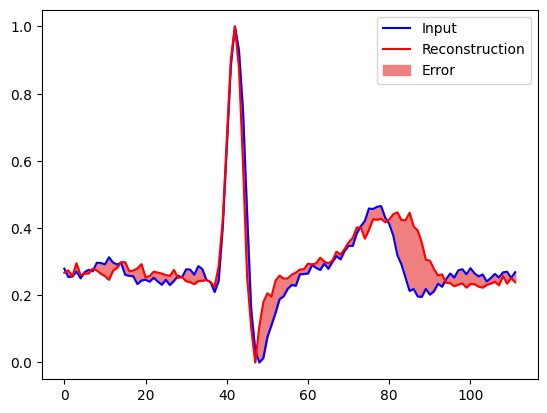

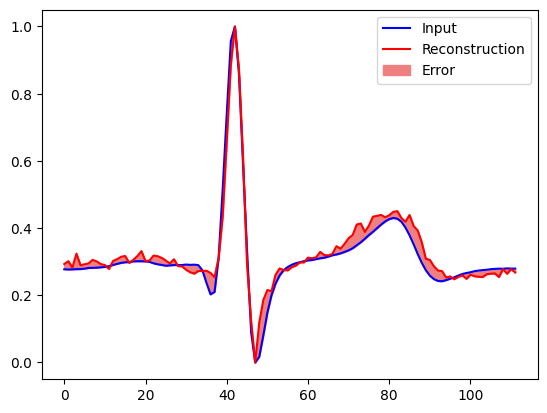

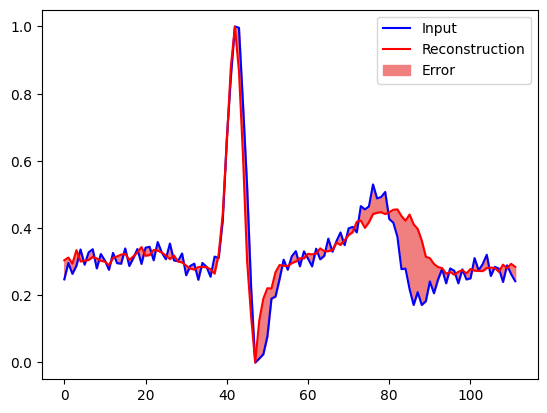

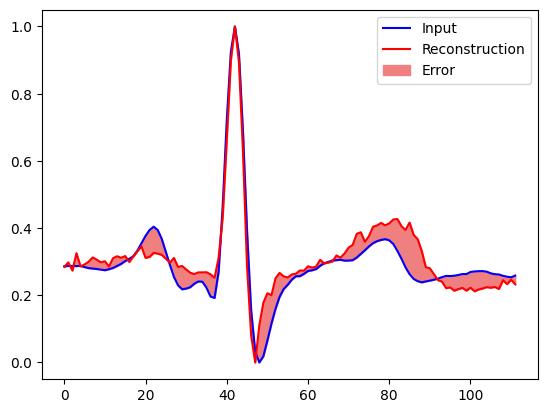

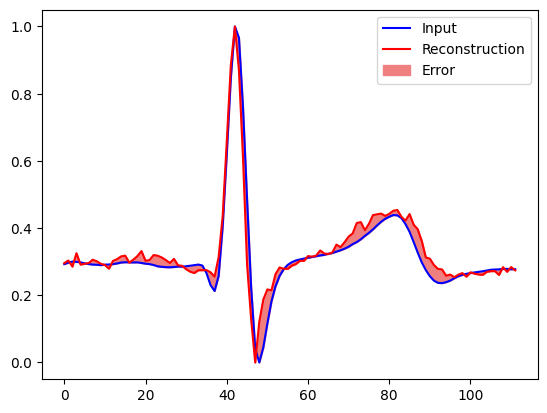

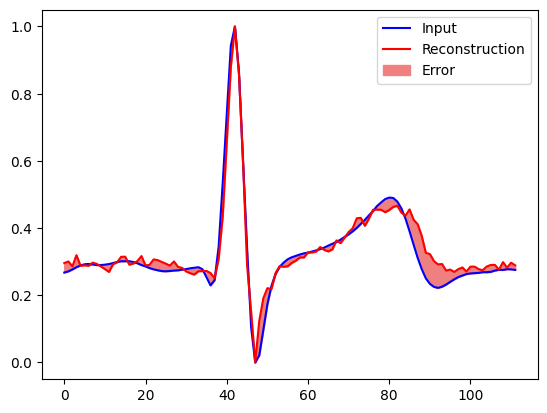

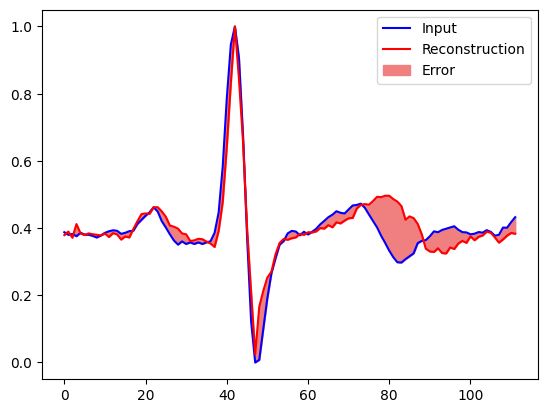

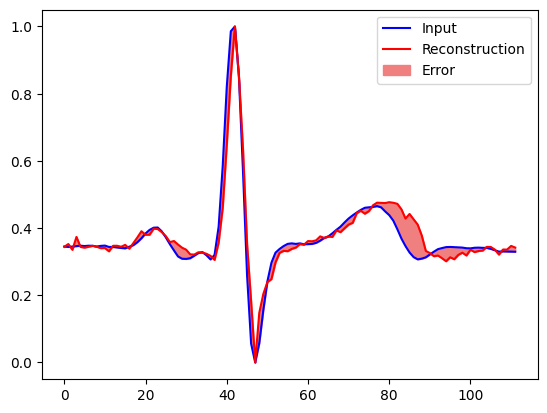

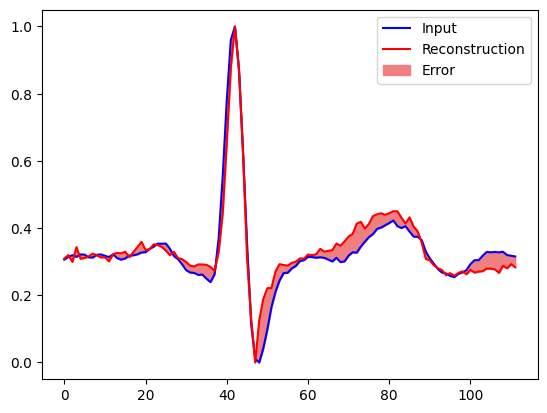

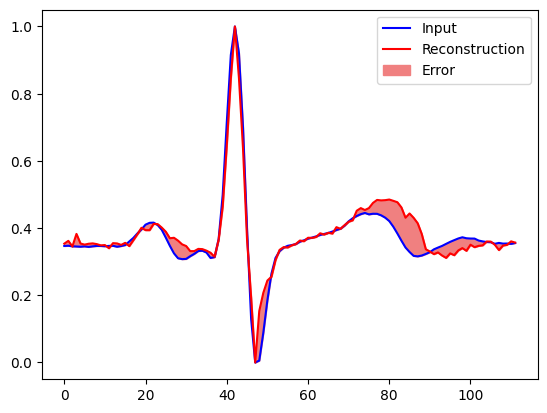

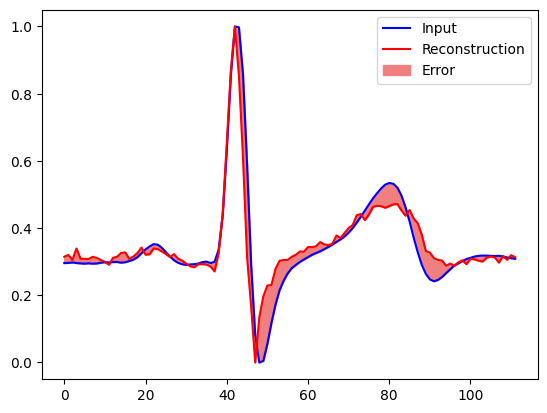

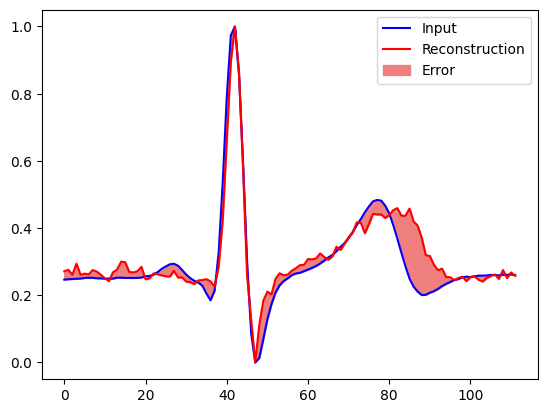

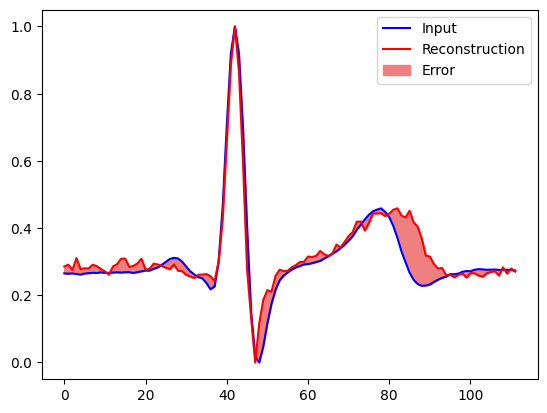

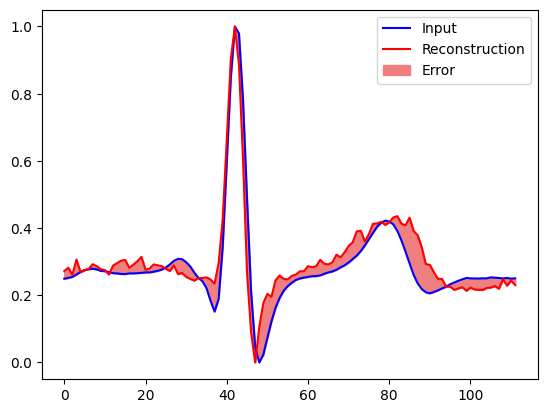

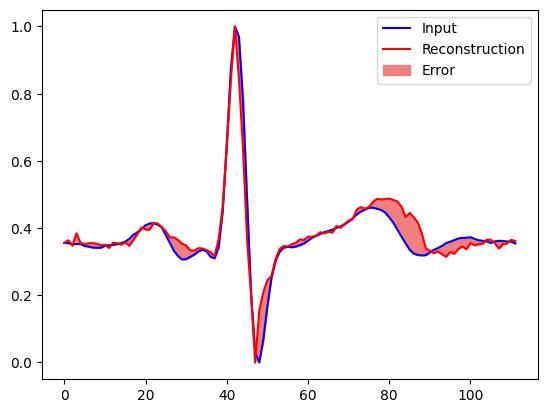

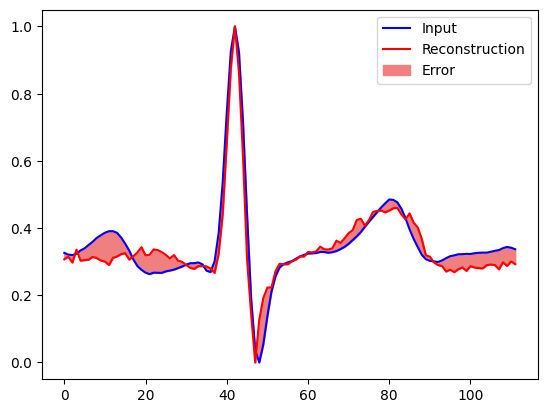

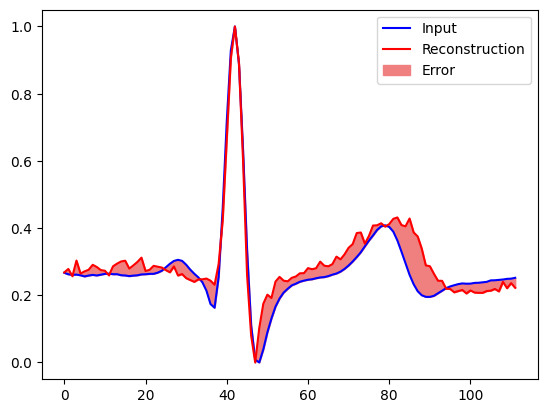

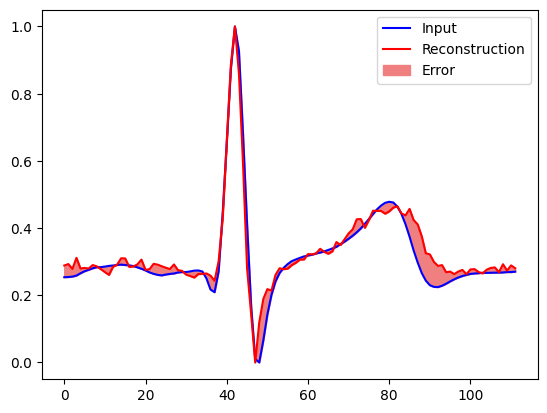

In [ ]:
for i in random.sample(range(x_test.shape[0]), 30):
  plot_anomaly(x_test, i)

## Pruning vs Limited Model

In [ ]:
# hyperparams
batch_size = 16
dropout = 0.2
epochs = 100
patience = 5
regularization = 0.000 # troppi pochi pesi, non va regularization

class Autoencoder(Model):
    def __init__(self, size=100, dropout=0):
        super(Autoencoder, self).__init__(name="ECG_Autoencoder")
        self.size = size

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(5, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dropout(dropout),
            layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dense(2, activation='relu', kernel_regularizer=regularizers.l1(regularization))
        ], name="Encoder")

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dropout(dropout),
            layers.Dense(5, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dense(self.size, activation='hard_sigmoid')
        ], name="Decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# test del modello con un dummy
autoencoder = Autoencoder(x_train.shape[1], dropout=dropout)
dummy_input = tf.zeros((1, x_train.shape[1]))
output = autoencoder(dummy_input)
print("Dimensione output dal modello:", output.shape)
autoencoder.compile(optimizer='adam', loss='mae')
n_weights = autoencoder.encoder.count_params() + autoencoder.decoder.count_params()
print(f"Numero totale di pesi addestrabili: {n_weights}, size in Byte: {n_weights*4}")
print(f"Numero pesi Encoder: {autoencoder.encoder.count_params()}")
print(f"Numero pesi Decoder: {autoencoder.decoder.count_params()}")

Dimensione output dal modello: (1, 112)
Numero totale di pesi addestrabili: 1308, size in Byte: 5232
Numero pesi Encoder: 599
Numero pesi Decoder: 709


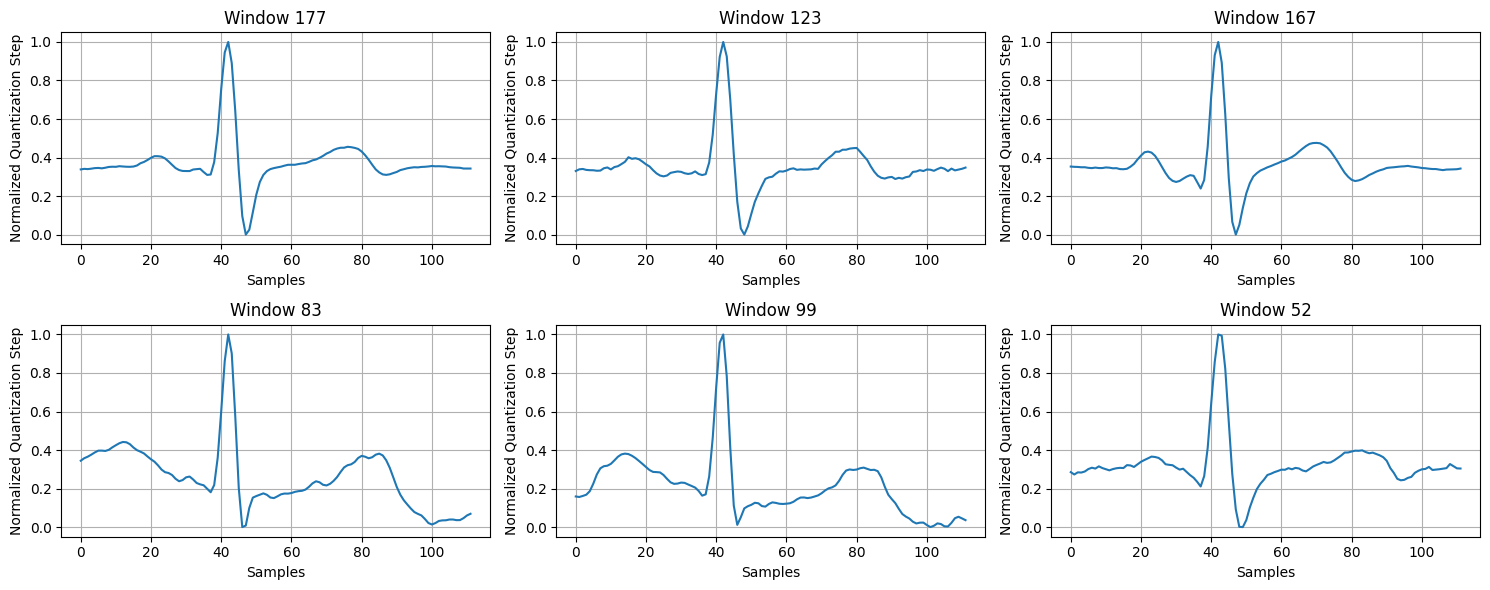

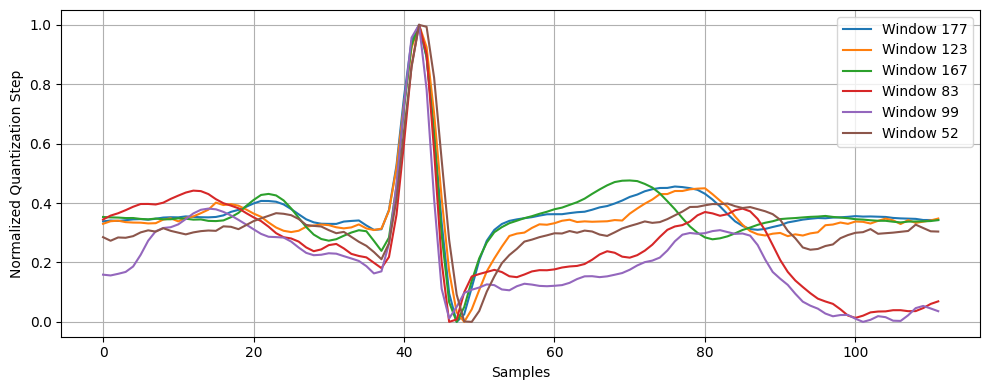

Original Shape: (200, 112)
x_train shape: (150, 112), x_val shape: (50, 112)


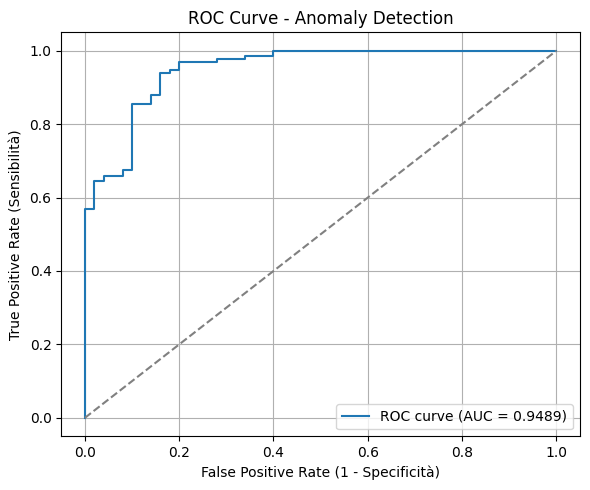


=== Massima Sensibilità (max TPR) ===
Soglia: 0.046507
True Positive Rate (Sensibilità): 1.0000
False Positive Rate: 0.4000
Accuracy: 0.8901


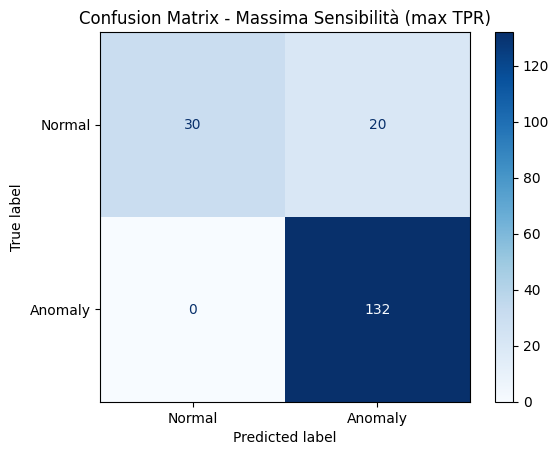


=== Minimo FPR (max Specificità) ===
Soglia: inf
True Positive Rate (Sensibilità): 0.0000
False Positive Rate: 0.0000
Accuracy: 0.2747


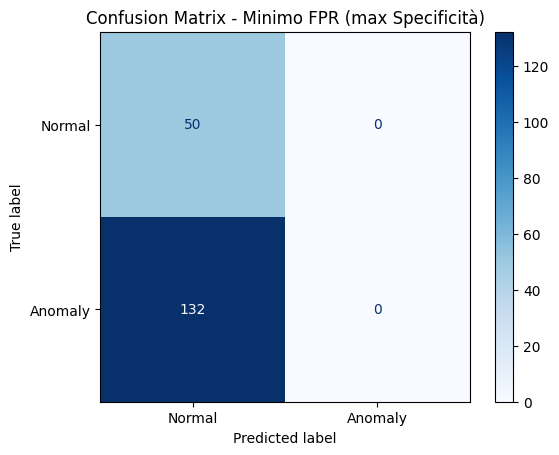


=== Punto più vicino a (0,1) ===
Soglia: 0.070353
True Positive Rate (Sensibilità): 0.9394
False Positive Rate: 0.1600
Accuracy: 0.9121


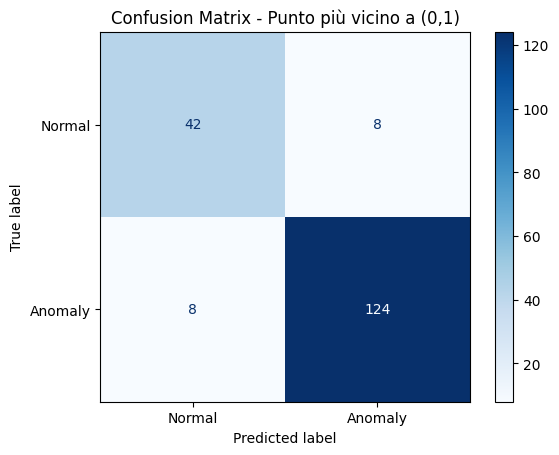

In [38]:
response = requests.get(url_limited)
with open('autoencoder_tuned_limited.weights.h5', 'wb') as f:
    f.write(response.content)
autoencoder.load_weights('autoencoder_tuned_limited.weights.h5')
thresholds = evaluate_thresholds(autoencoder, x_combined_val, x_anomaly)

In [40]:
threshold = thresholds['Massima Sensibilità (max TPR)']['threshold']
test_loss = tf.reduce_mean(tf.abs(autoencoder(x_test) - x_test), axis=1).numpy()
anomalous_indices = np.where(test_loss >= threshold)[0]
print(f"Elementi sopra la soglia: {len(anomalous_indices)} su {len(x_test)}")
print(f"Percentuale: {len(anomalous_indices) / len(x_test) * 100:.2f}%")
anomalous_indices

Elementi sopra la soglia: 2448 su 2541
Percentuale: 96.34%


array([   0,    1,    2, ..., 2538, 2539, 2540])

## Future Steps

Concludendo, il modello ha ottenuto ottimi risultati anche in presenza di un basso costo computazionale e con un numero limitato di dati etichettati. Questo dimostra che l’autoencoder può rappresentare una valida alternativa ai classificatori tradizionali, soprattutto in contesti dove l’etichettatura è onerosa o poco praticabile.

Naturalmente, per validare ulteriormente l’efficacia del modello, futuri sviluppi dovranno includere:
- analisi con diverse anomalie con diverse derivazioni ECG;
- integrazione di tecniche di quantizzazione per l’ottimizzazione su microcontrollori;
- utilizzo di CNN 1D, per migliorare la capacità del modello di catturare pattern temporali complessi.

Altri modelli promettenti da esplorare includono il VAE (Variational Autoencoder) e il CI-VAE (Class-Informed VAE), che integra un classificatore nello spazio latente. Tuttavia, questi approcci sono stati momentaneamente scartati a causa delle risorse limitate e del tempo a disposizione per la tesi, oltre al maggior costo computazionale richiesto.

Infine, un’interessante prospettiva futura consiste nell’implementazione di un Fine Tuning locale del modello direttamente sul microcontrollore, per adattarlo all’utente specifico con un impatto minimo sulle risorse.